# DATA 512 Project - Analysis of Google Search Patterns and Impact of Mask Mandate during the COVID-19 pandemic

The county assigned for analysis is Milwaukee from the state of Wisconsin. Below are the detailed steps of the COVID 19 infection analysis performed on the provided data and inference as to how is mask mandate policy impacted the progression of the virus.

Note: Inference on all the analysis and graphs are listed at the bottom of the notebook

# Step 0 - Data Aquisition


### Importing the python packages and data

In [ ]:
!pip install pmdarima
!pip install ruptures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 26.6 MB/s 


In [ ]:
warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import matplotlib.dates
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import ruptures
import warnings
import os
import time
import datetime
import matplotlib.ticker as plticker
import seaborn as sns
import statsmodels.api as sm
from scipy import signal
import pmdarima as pm
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

### Import the data

In [ ]:
raw_us_cases = pd.read_csv("/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/data/RAW_us_confirmed_cases.csv")
raw_us_deaths = pd.read_csv("/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/data/RAW_us_deaths.csv")
mask_use_by_county = pd.read_csv("/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/data/mask-use-by-county.csv")
#mask_mandates_april_2020_aug_2021 = pd.read_csv("/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/archive/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
mask_mandates_april_2020_aug_2021 = pd.read_csv("/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/data/mask-mandate-milwaukee.csv")
df_data = pd.read_csv('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/data-512-project/Part1 Data.csv')
df_trends_raw = pd.read_excel('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/data-512-project/US_WI_55079.xlsx')
df_columns = pd.read_excel('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/data-512-project/trends_columns.xlsx')
df_vaccine = pd.read_excel('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/data-512-project/Vaccination Search Insights.xlsx')

# Step 1 - COVID Infection Analysis

The common research question that you are to answer is:

How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?

### Cleaning the data set

#### Total COVID Cases

In [ ]:
raw_mwk_cases = raw_us_cases[(raw_us_cases["Province_State"] == "Wisconsin") & (raw_us_cases["Admin2"] == "Milwaukee")]
#first 12 columns are general info about the state
mwk_general_info = raw_mwk_cases[raw_mwk_cases.columns[0:11]]
#this is useful later
mwk_FIPS = mwk_general_info["FIPS"].values[0]
#lets take all the columns with deaths by date and pivot the table + make the date its own column. Schema of date, deaths
mwk_cases_by_date =  raw_mwk_cases[raw_mwk_cases.columns[11:]]
mwk_cases_by_date = pd.DataFrame(mwk_cases_by_date.iloc[0])
mwk_cases_by_date = mwk_cases_by_date.reset_index()
mwk_cases_by_date.columns = ["date", "cases"]

In [ ]:
mwk_cases_by_date['date'] = pd.to_datetime(mwk_cases_by_date['date'])
mwk_cases_by_date = mwk_cases_by_date[(mwk_cases_by_date['date'] >= '2020-02-01') & (mwk_cases_by_date['date'] <= '2021-10-01')]
df_cases = mwk_cases_by_date.copy()
df_cases['cum_cases'] = df_cases['cases']
df_cases['cases'] = df_cases['cum_cases'] - df_cases.shift(periods = 1)['cum_cases']
df_cases['cases'] = df_cases['cases'].fillna(0).astype('int64')
df_cases = df_cases.set_index('date')

Calculating 3 day moving average to ensure there are no side effects of datification

In [ ]:
df_cases['cases'] = df_cases['cases'].rolling(3).mean()
df_cases['cases'] = df_cases['cases'].fillna(0).astype('int64')

#### Total COVID Deaths

In [ ]:
raw_mwk_deaths = raw_us_deaths[(raw_us_deaths["Province_State"] == "Wisconsin") & (raw_us_deaths["Admin2"] == "Milwaukee")]
#lets take all the columns with deaths by date and pivot the table + make the date its own column. Schema of date, deaths
mwk_deaths_by_date =  raw_mwk_deaths[raw_mwk_deaths.columns[11:]]
mwk_deaths_by_date = pd.DataFrame(mwk_deaths_by_date.iloc[0])
mwk_deaths_by_date = mwk_deaths_by_date.reset_index()
mwk_deaths_by_date.columns = ["date", "deaths"]
mwk_population = mwk_deaths_by_date[mwk_deaths_by_date['date']=='Population']['deaths'][0]
mwk_deaths_by_date = mwk_deaths_by_date[1:]

In [ ]:
mwk_deaths_by_date['date'] = pd.to_datetime(mwk_deaths_by_date['date'])
mwk_deaths_by_date = mwk_deaths_by_date[(mwk_deaths_by_date['date'] >= '2020-02-01') & (mwk_deaths_by_date['date'] <= '2021-10-01')]
df_deaths = mwk_deaths_by_date.copy()
df_deaths['cum_deaths'] = df_deaths['deaths']
df_deaths['deaths'] = df_deaths['cum_deaths'] - df_deaths.shift(periods = 1)['cum_deaths']
df_deaths['deaths'] = df_deaths['deaths'].fillna(0).astype('int64')
df_deaths = df_deaths.set_index('date')

Remove days where negative value of deaths are reported

In [ ]:
df_deaths['deaths'] = np.where(df_deaths['deaths'] < 0, 0, df_deaths['deaths'])

Calculating 3 day moving average to ensure there are no side effects of datification

In [ ]:
df_deaths['deaths'] = df_deaths['deaths'].rolling(3).mean()
df_deaths['deaths'] = df_deaths['deaths'].fillna(0).astype('int64')

#### Mask Mandate Information

In [ ]:
#use fips to narrow our other datasets when possible. CDC unfortunately breaks FIPS down by state and county so we cant use it here
mwk_mask_use_july2_july14_2020 = mask_use_by_county[mask_use_by_county["COUNTYFP"] == mwk_FIPS]
mwk_mask_mandates_april_2020_aug_2021 = mask_mandates_april_2020_aug_2021[(mask_mandates_april_2020_aug_2021["State_Tribe_Territory"] == "WI") &\
     (mask_mandates_april_2020_aug_2021['County_Name'] == 'Milwaukee County')]
#lets set N/A values from before mandates came into effect to no. Technically people were not required to wear masks when covid did not exist in the state, no works here.
mwk_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"] = mwk_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"].fillna("No")
df_mask_mandates = mwk_mask_mandates_april_2020_aug_2021[['date', 'Face_Masks_Required_in_Public']]
df_mask_mandates['date'] = pd.to_datetime(df_mask_mandates['date'])
df_mask_mandates = df_mask_mandates.sort_values('date').set_index('date')
df_mask_mandates.head()

<ipython-input-11-0c7f0360aa65>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mask_mandates['date'] = pd.to_datetime(df_mask_mandates['date'])


,Face_Masks_Required_in_Public
date,
2020-04-10,No
2020-04-11,No
2020-04-12,No
2020-04-13,No
2020-04-14,No


#### Combined Dataframe with cases and deaths

In [ ]:
df_main = pd.merge(df_cases, df_deaths, left_index = True, right_index = True)
df_main = pd.merge(df_main, df_mask_mandates, how = 'left', left_index = True, right_index = True)
df_main['population'] = mwk_population
#df_main['current_population'] = df_main['population'] - df_main['deaths']
df_main = df_main.rename(columns = {'Face_Masks_Required_in_Public': 'mask_required'})
df_main.head()

,cases,cum_cases,deaths,cum_deaths,mask_required,population
date,,,,,,
2020-02-01,0,0,0,0,NaN,945726
2020-02-02,0,0,0,0,NaN,945726
2020-02-03,0,0,0,0,NaN,945726
2020-02-04,0,0,0,0,NaN,945726
2020-02-05,0,0,0,0,NaN,945726


In [ ]:
df_main.to_csv('Part1 Data.csv')

### Visualizing the Cases and Deaths data

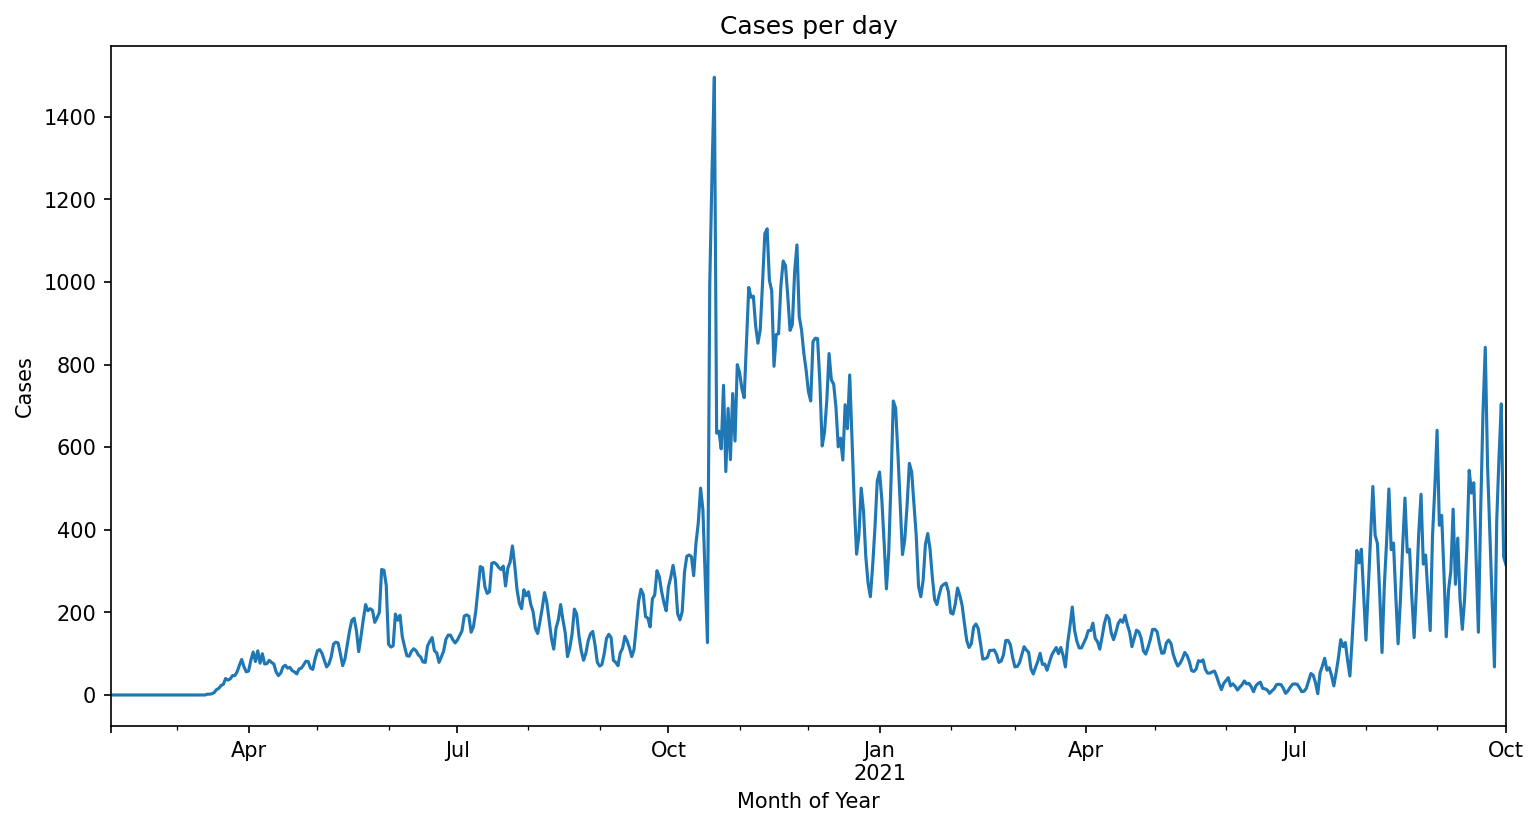

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
df_main['cases'].plot()
plt.title('Cases per day')
plt.xlabel('Month of Year')
plt.ylabel('Cases')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/EDA/cases_per_day.png')

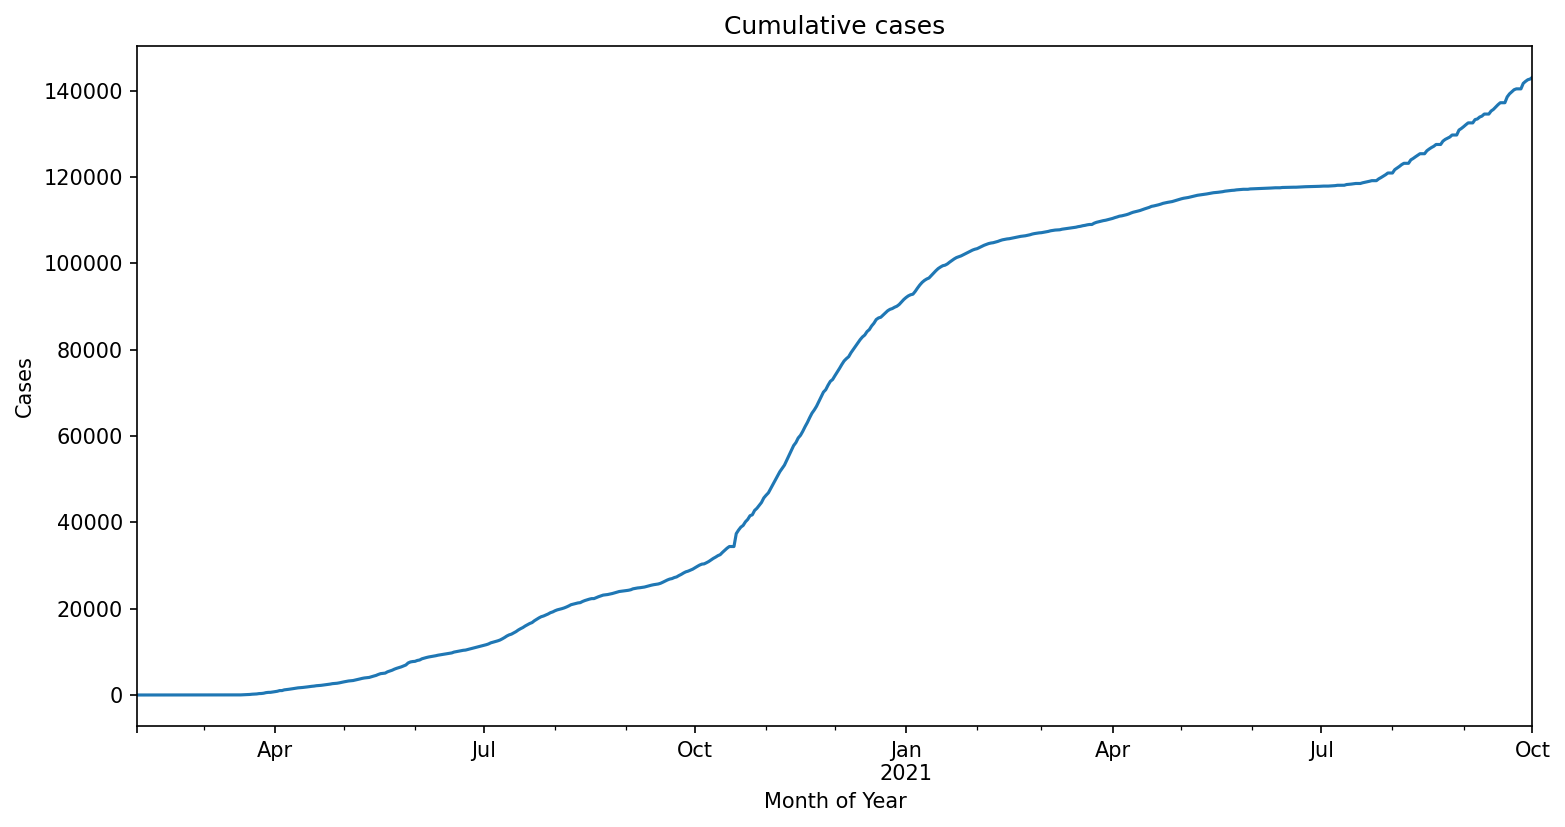

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
df_main['cum_cases'].plot()
plt.title('Cumulative cases')
plt.xlabel('Month of Year')
plt.ylabel('Cases')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/EDA/cumulative_cases.png')

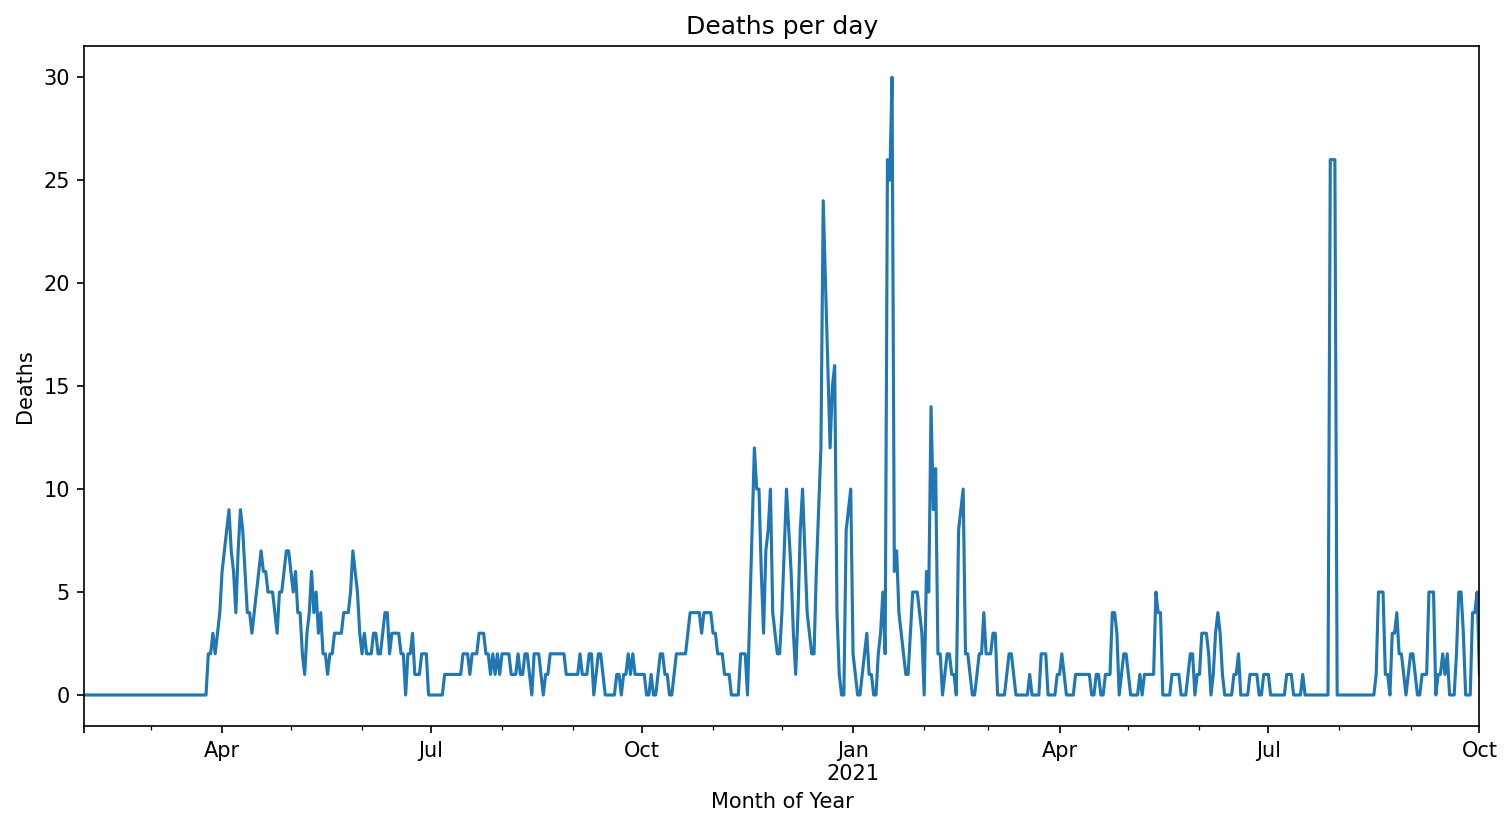

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
df_main['deaths'].plot()
plt.title('Deaths per day')
plt.xlabel('Month of Year')
plt.ylabel('Deaths')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/EDA/deaths_per_day.png')

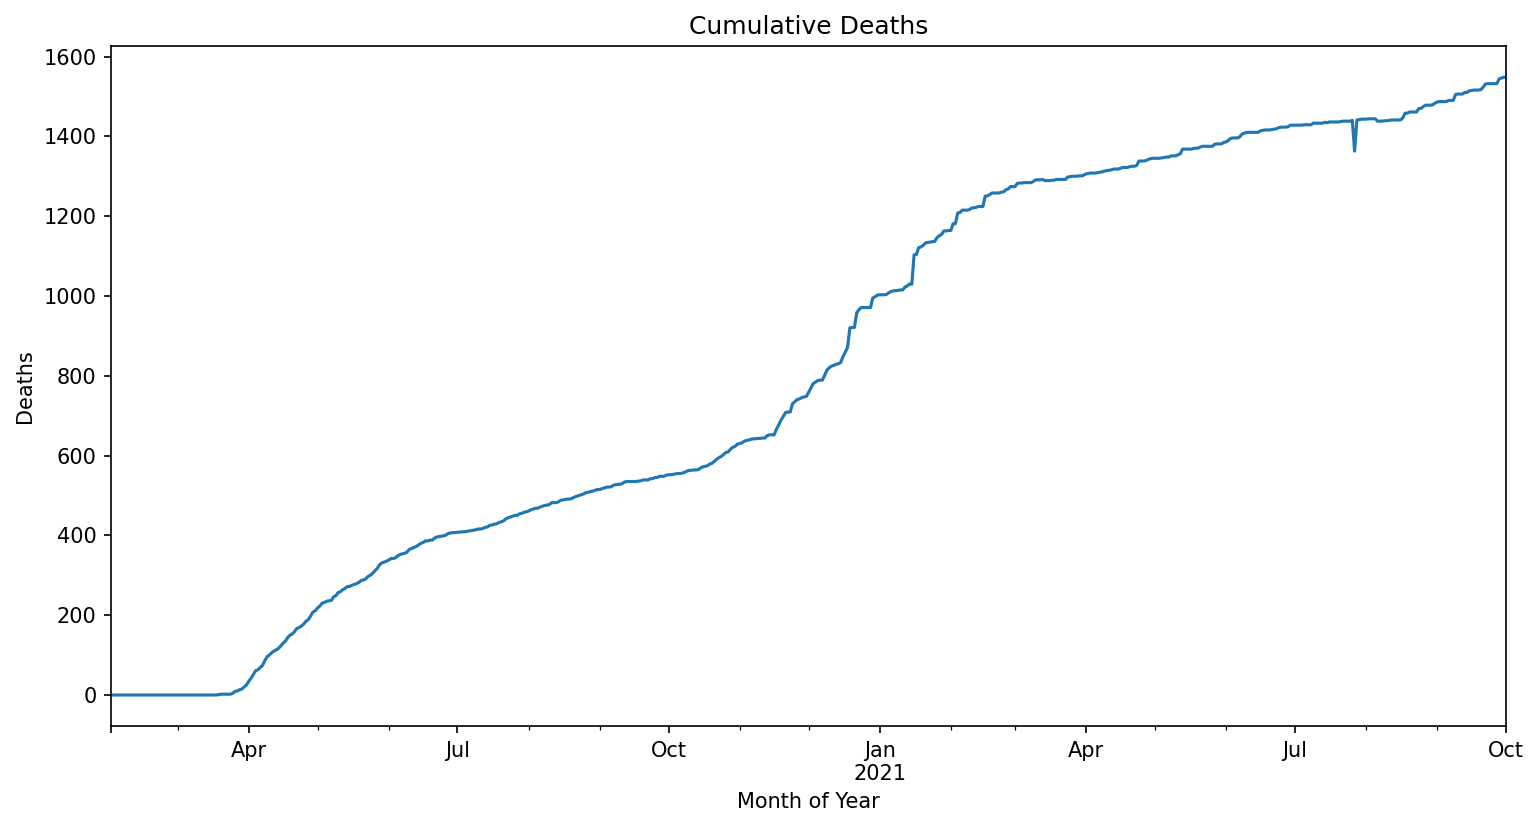

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
df_main['cum_deaths'].plot()
plt.title('Cumulative Deaths')
plt.xlabel('Month of Year')
plt.ylabel('Deaths')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/EDA/cumulative_deaths.png')

### Visualize the mask mandate progression

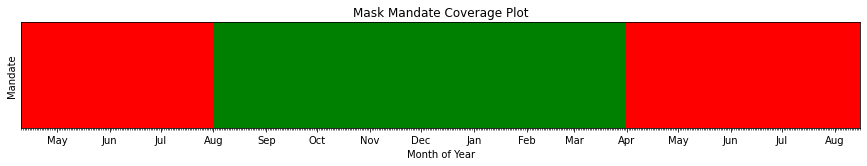

<Figure size 432x288 with 0 Axes>

In [ ]:
holder = df_main['mask_required'].reset_index()

fig, ax= plt.subplots(figsize=(12,2))

# plot green for event:
s1 = holder[holder['mask_required'] == 'Yes']
inxval = matplotlib.dates.date2num(pd.to_datetime(s1.date))
times= list(zip(inxval, np.ones(len(s1))))
plt.broken_barh(times, (-1,1), color="green")

# plot red for event:
s2 = holder[holder['mask_required'] == 'No']
inxval = matplotlib.dates.date2num(pd.to_datetime(s2.date))
times= list(zip(inxval, np.ones(len(s2))))
plt.broken_barh(times, (-1,1), color="red")

ax.margins (0)
ax.set_yticks([])
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
monthFmt = matplotlib.dates.DateFormatter("%b")

ax. xaxis.set_major_formatter(monthFmt)

plt.tight_layout()
plt.title('Mask Mandate Coverage Plot')
plt.xlabel('Month of Year')
plt.ylabel('Mandate')
plt.show()

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/mask_mandate_coverage.png')

# Step 2: Visualize the Infection Analysis

In this step we want you to create a graph that visualizes how the course of the disease was changed by masking policies. For your county, you should create a time series showing the changes in the derivative function of the rate of infection. Your graph should indicate days where masking policies were in effect (or not) and whether the difference in the derivative function was significant. Optionally, you can add a second time series that shows the actual rate of infection.


### Positive Cases Per Capita or Incidence Rate

Below is the logic used for spread category classification

Red: Uncontrolled substantial spread	15 or more cases

Orange: Controlled substantial spread	7 to 15 cases

Green: Low spread	Less than 7 cases

In [ ]:
df_main['current_population'] = df_main['population'] - df_main['cum_deaths']
df_main['incidence_rate'] = df_main['cases'] * 100000 / df_main['current_population']
df_main['spread_category'] = np.where(df_main['incidence_rate'] >= 15, 'red' , np.where(df_main['incidence_rate'] >= 7, 'orange' , 'green'))

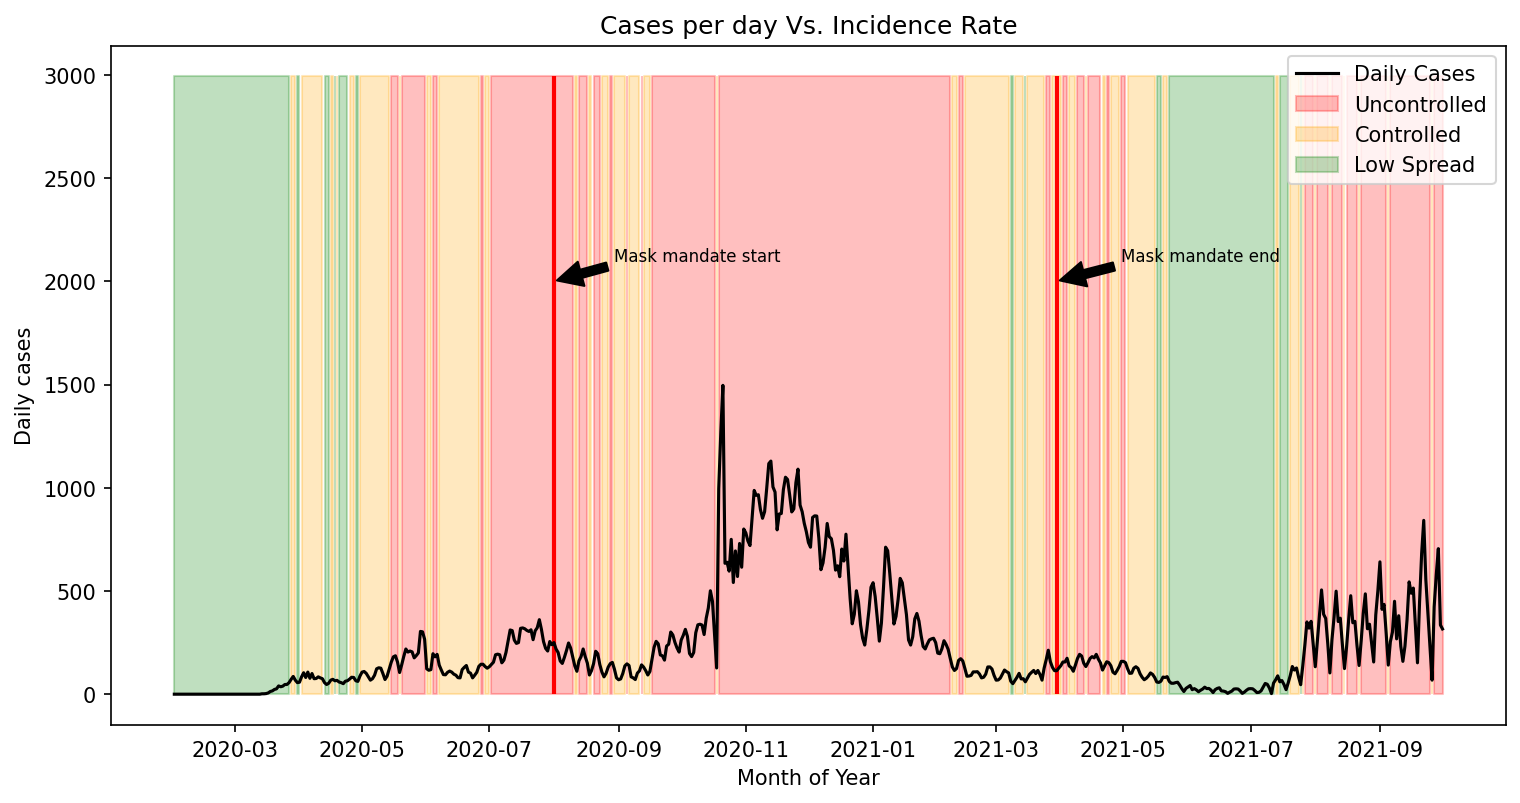

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
y = df_main['cases']
x = df_main.index
z = df_main['spread_category']
plt.plot(x, y, color='black')

plt.fill_between(x, 0, 2*max(y), where = z == 'red', color='red', alpha=0.25)
plt.fill_between(x, 0, 2*max(y), where = z == 'orange', color='orange', alpha=0.25)
plt.fill_between(x, 0, 2*max(y), where = z == 'green', color='green', alpha=0.25)

#plt.axvline(x = pd.to_datetime('2020-08-01'), col)
plt.vlines(x = [pd.to_datetime('2020-08-01'), pd.to_datetime('2021-03-30')], ymin=[0, 0], ymax=[2*max(y), 2*max(y)], colors='red', ls='-', lw=2, label='Mask Mandate - Start to End')
plt.annotate('Mask mandate start', xy=(pd.to_datetime('2020-08-01'), 2000), xytext=(pd.to_datetime('2020-08-30'), 2100), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Mask mandate end', xy=(pd.to_datetime('2021-03-30'), 2000), xytext=(pd.to_datetime('2021-04-30'), 2100), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Cases per day Vs. Incidence Rate')
plt.xlabel('Month of Year')
plt.ylabel('Daily cases')
plt.legend(['Daily Cases', 'Uncontrolled', 'Controlled', 'Low Spread'])

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/cases_per_capita.png')

### Growth Factor

Growth factor is the change in confirmed cases today compared to the change yesterday. The number of confirmed cases is increasing in many days and there are two scenarios. Growth factor is larger than 1 and the number of cases is rapidly increasing or Growth factor is less than 1.

Where C is the number of confirmed cases,

Growth Factor=ΔCn / ΔCn−1

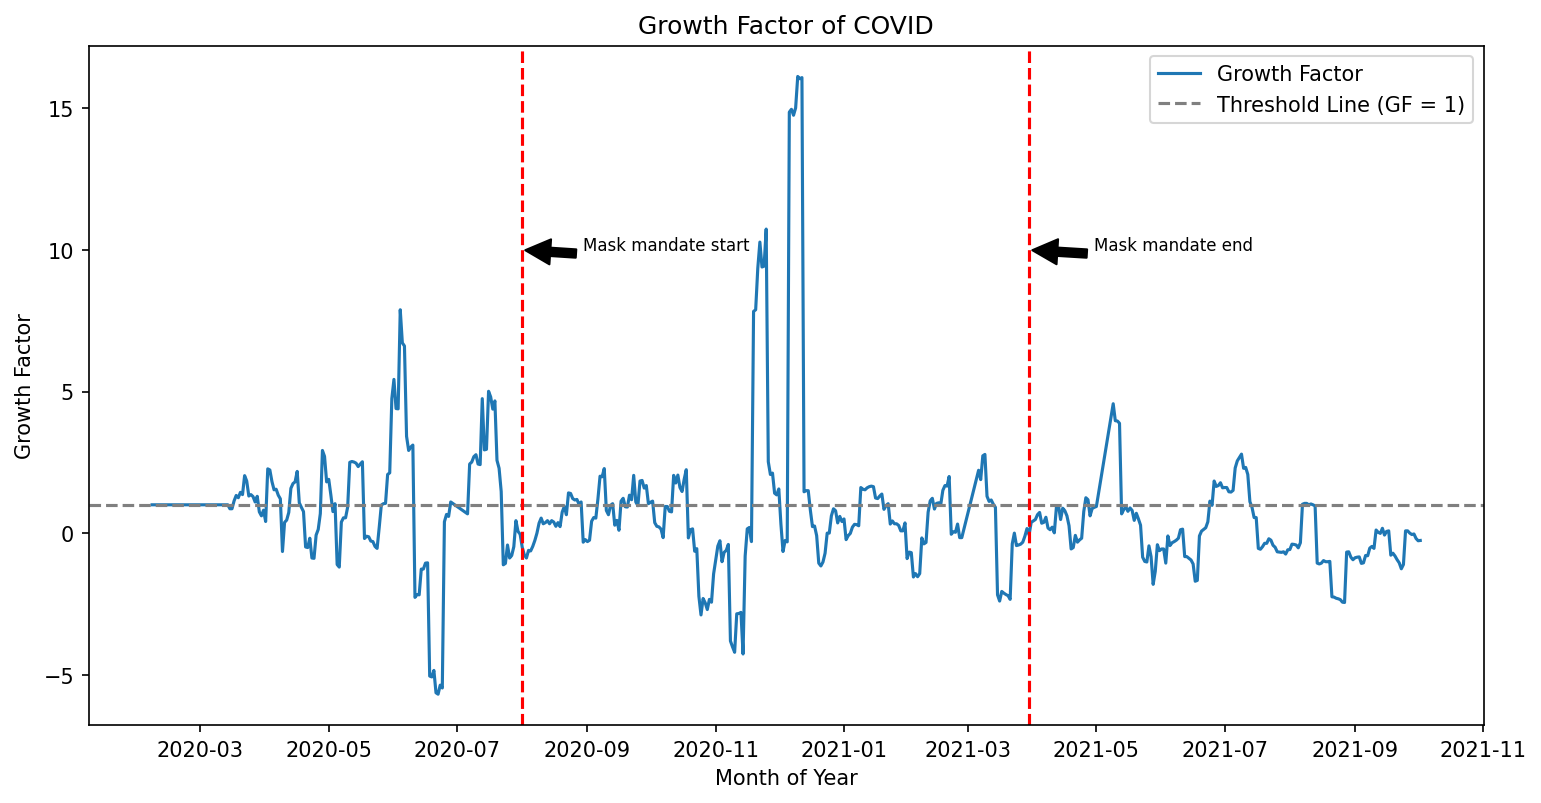

In [ ]:
# Growth factor: (delta Number_n) / (delta Number_n)
df = df_main['cases']
df = df.diff() / df.diff().shift(freq="D")
df = df.replace(np.inf, np.nan).fillna(1.0)
# Rolling mean (window: 7 days)
df = df.rolling(7).mean().dropna()

plt.figure(figsize=(12, 6), dpi=150)
# round: 0.01
growth_value_df = df.round(2)
plt.plot(growth_value_df)

plt.axhline(y = 1, color = 'gray', linestyle = '--', label = 'Base Growth Factor (GF = 1)')
plt.axvline(x = pd.to_datetime('2020-08-01'), color = 'red', linestyle = '--', label = 'Mask Mandate Start')
plt.axvline(x = pd.to_datetime('2021-03-30'), color = 'red', linestyle = '--', label = 'Mask Mandate End')
plt.annotate('Mask mandate start', xy=(pd.to_datetime('2020-08-01'), 10), xytext=(pd.to_datetime('2020-08-30'), 10), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Mask mandate end', xy=(pd.to_datetime('2021-03-30'), 10), xytext=(pd.to_datetime('2021-04-30'), 10), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('Growth Factor of COVID')
plt.xlabel('Month of Year')
plt.ylabel('Growth Factor')

plt.legend(['Growth Factor', 'Threshold Line (GF = 1)'])

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/growth_factor.png')

### Modeling the SIR

β(t)	Transmission or influence coefficient

α(t)	Per-capita recovery rate (its reciprocal is infectious period)

γ(t)	Per-capita rate of losing immunity or relapse rate

μ(t)	Per-capita mortality or departure rate

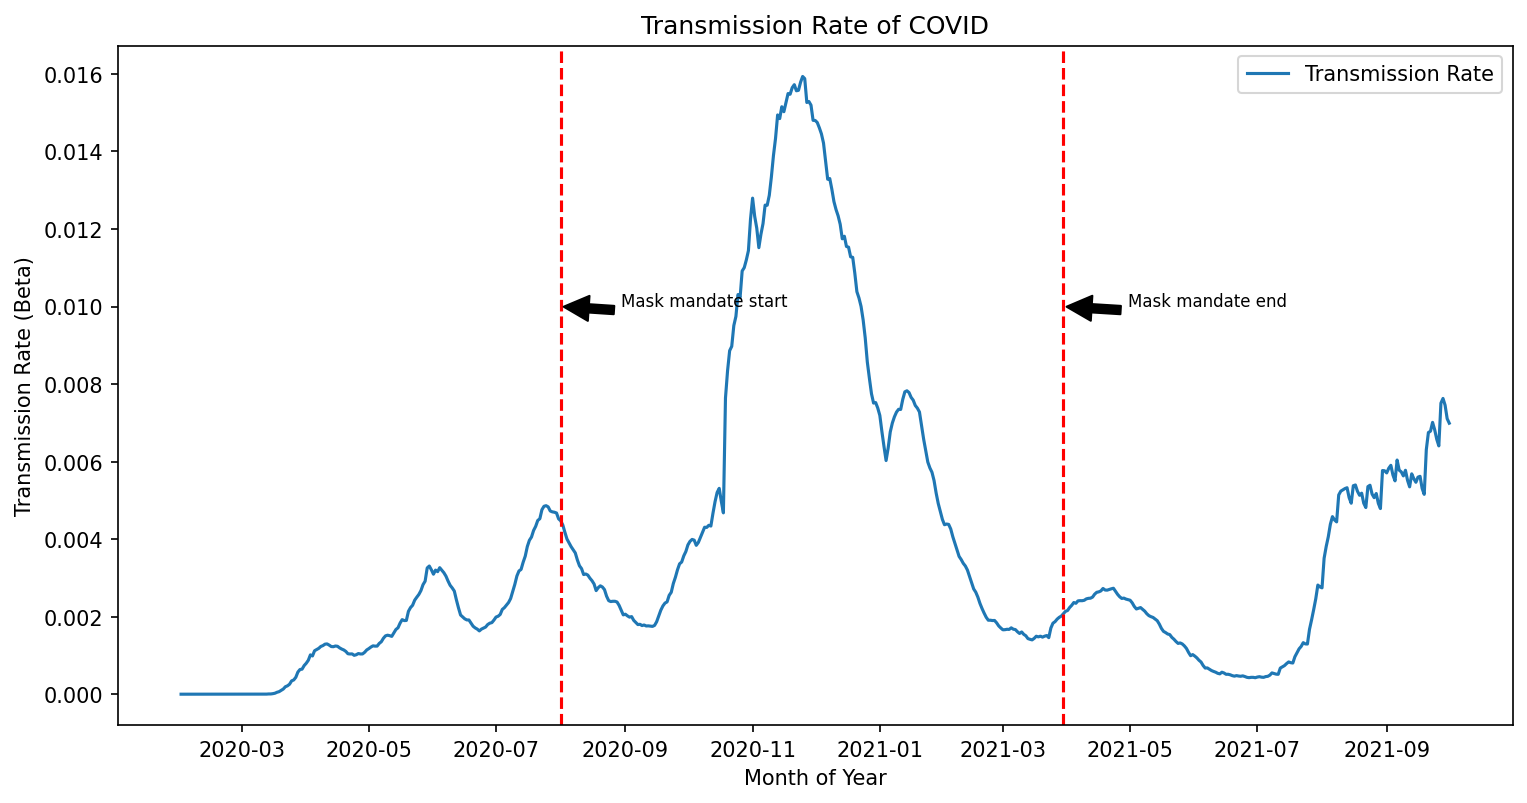

In [ ]:
df_main['removed'] = df_main['cases']
df_main['removed'] = df_main['removed'].shift(14).fillna(0).astype('int64')
df_main['cum_removed'] = df_main['removed'].cumsum()
df_main['infected'] = df_main['cum_cases'] - df_main['cum_removed']

df_main['susceptible'] = df_main['population'] - df_main['infected'].shift(1) - df_main['removed'].shift(1)
df_main['susceptible'] = df_main['susceptible'].fillna(mwk_population)

df_main['transmission_rate'] = df_main['infected'] / df_main['susceptible']
df_main['infection_rate'] = df_main['cases'] * 100 / df_main['susceptible']
df_main['r0'] = df_main['transmission_rate'] / 0.07
plt.figure(figsize=(12, 6), dpi=150)
plt.plot(df_main['transmission_rate'])
plt.axvline(x = pd.to_datetime('2020-08-01'), color = 'red', linestyle = '--', label = 'Mask Mandate Start')
plt.axvline(x = pd.to_datetime('2021-03-30'), color = 'red', linestyle = '--', label = 'Mask Mandate End')
plt.annotate('Mask mandate start', xy=(pd.to_datetime('2020-08-01'), 0.01), xytext=(pd.to_datetime('2020-08-30'), 0.01), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Mask mandate end', xy=(pd.to_datetime('2021-03-30'), 0.01), xytext=(pd.to_datetime('2021-04-30'), 0.01), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Transmission Rate of COVID')
plt.xlabel('Month of Year')
plt.ylabel('Transmission Rate (Beta)')

plt.legend(['Transmission Rate'])

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/transmission_rate.png')

### Visualizing the change points

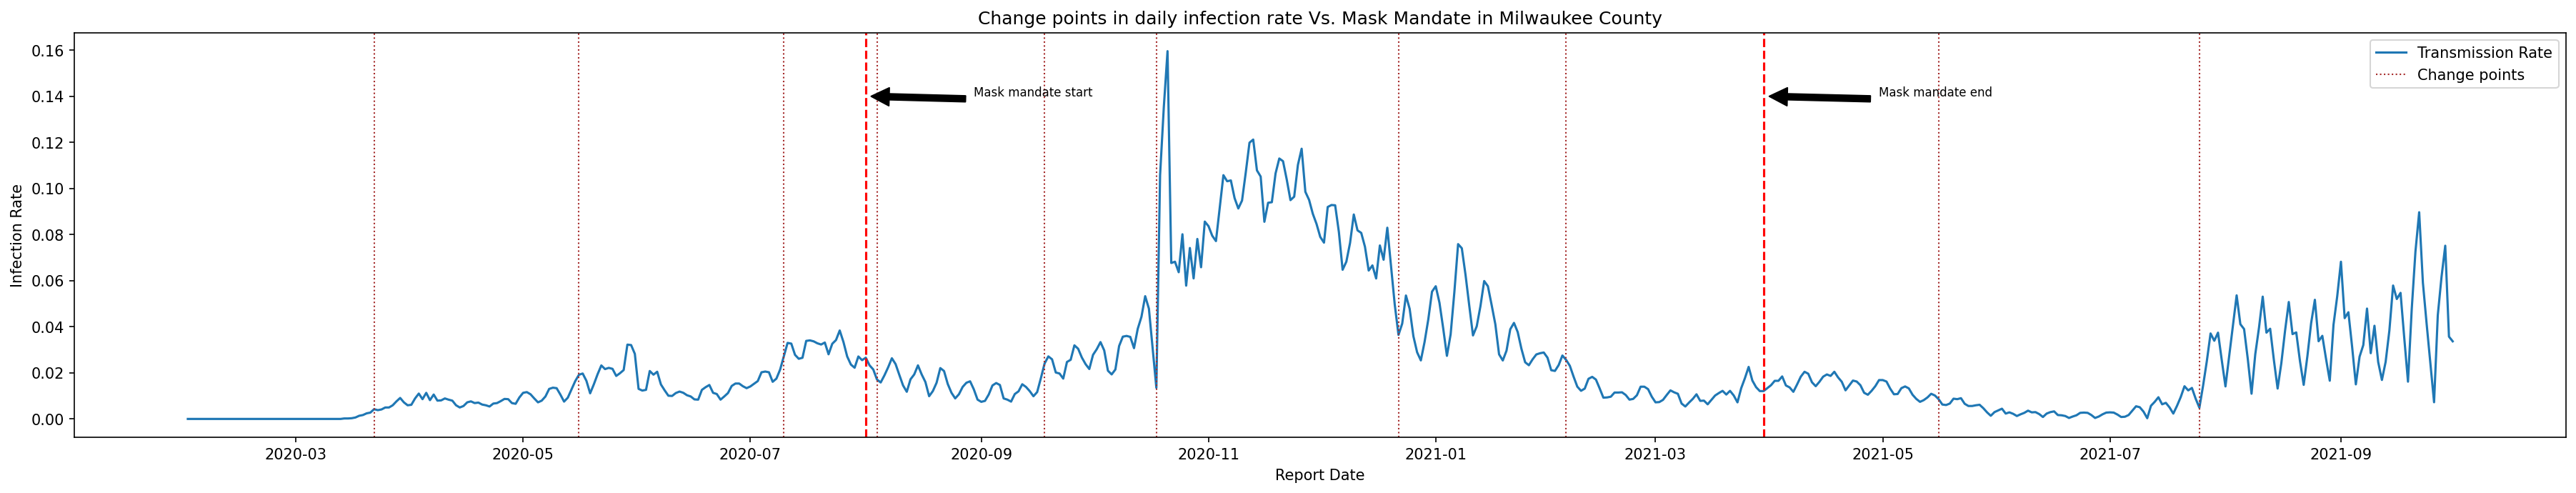

In [ ]:
import ruptures as rpt
data = np.array(df_main['infection_rate'])

algo = rpt.Pelt(model="rbf").fit(data)
change_location = algo.predict(pen = 5)
change_location = df_main.iloc[change_location[:-1]].index.to_list()

plt.figure(figsize=(12, 6), dpi=150)
plt.plot(df_main['infection_rate'])
for x in change_location:
    plt.axvline(x, lw = 1, color = 'brown', linestyle = ':')

plt.axvline(x = pd.to_datetime('2020-08-01'), color = 'red', linestyle = '--', label = 'Mask Mandate Start')
plt.axvline(x = pd.to_datetime('2021-03-30'), color = 'red', linestyle = '--', label = 'Mask Mandate End')
plt.annotate('Mask mandate start', xy=(pd.to_datetime('2020-08-01'), 0.14), xytext=(pd.to_datetime('2020-08-30'), 0.14), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Mask mandate end', xy=(pd.to_datetime('2021-03-30'), 0.14), xytext=(pd.to_datetime('2021-04-30'), 0.14), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('Change points in daily infection rate Vs. Mask Mandate in Milwaukee County')
plt.xlabel('Report Date')
plt.ylabel('Infection Rate')

plt.legend(['Transmission Rate', 'Change points'])

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/infection_rate.png')

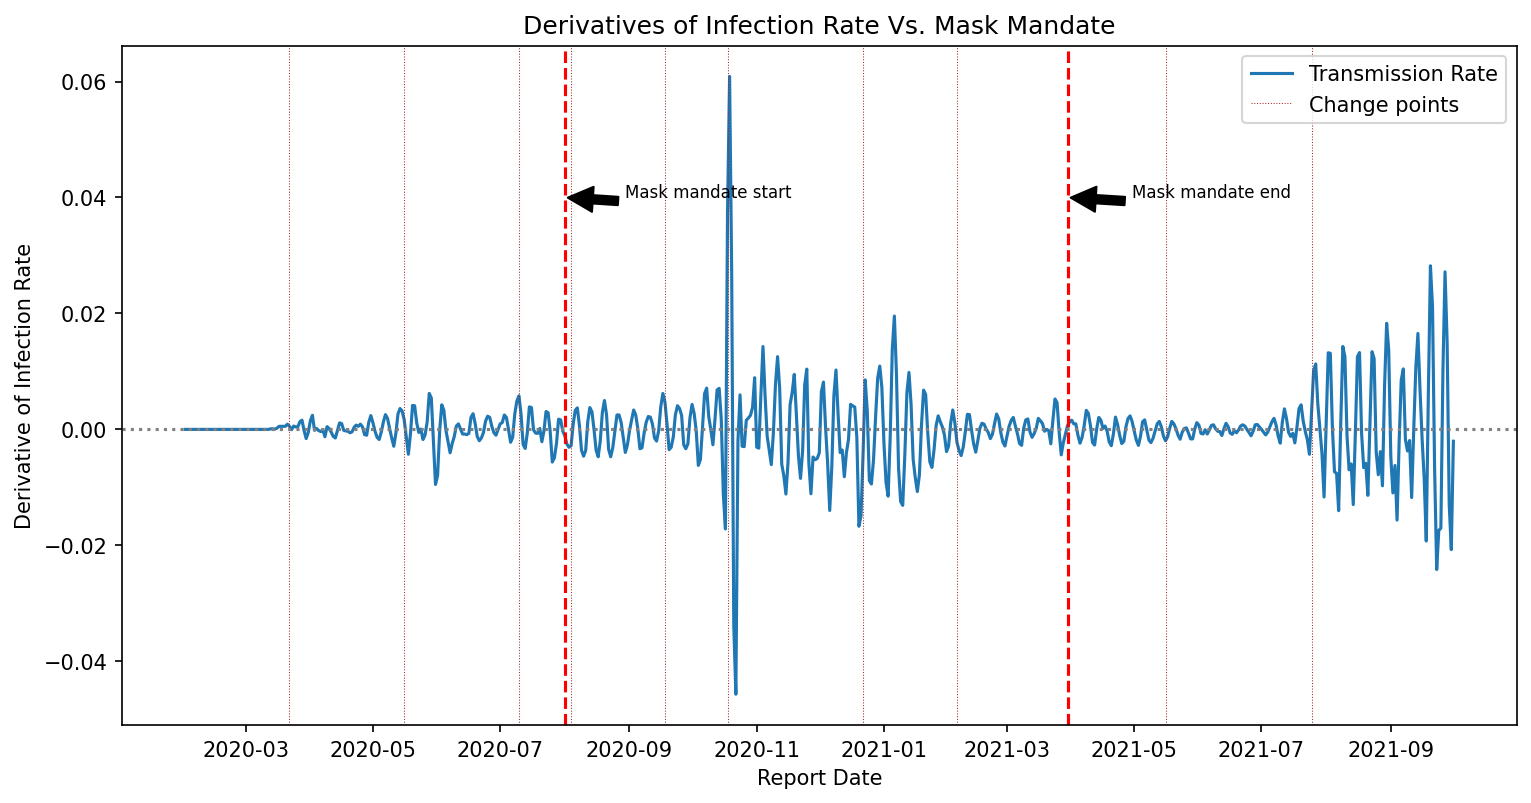

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)

df_main["derivative"] = pd.Series(np.gradient(df_main["infection_rate"]), df_main.index, name='derivative').values
plt.plot(df_main['derivative'])

for x in change_location:
    plt.axvline(x, lw = 0.5, color = 'brown', linestyle = ':')

plt.axhline(y = 0, color = 'gray', linestyle = ':', label = 'No change in infection rate')
plt.axvline(x = pd.to_datetime('2020-08-01'), color = 'red', linestyle = '--', label = 'Mask Mandate Start')
plt.axvline(x = pd.to_datetime('2021-03-30'), color = 'red', linestyle = '--', label = 'Mask Mandate End')
plt.annotate('Mask mandate start', xy=(pd.to_datetime('2020-08-01'), 0.04), xytext=(pd.to_datetime('2020-08-30'), 0.04), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Mask mandate end', xy=(pd.to_datetime('2021-03-30'), 0.04), xytext=(pd.to_datetime('2021-04-30'), 0.04), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('Derivatives of Infection Rate Vs. Mask Mandate')
plt.xlabel('Report Date')
plt.ylabel('Derivative of Infection Rate')

plt.legend(['Transmission Rate', 'Change points'])

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/derivative_infection_rate.png')

# Step 3 - Analysing the Google Seach Trends

In [ ]:
cols = list(df_columns['column'])
df_trends = df_trends_raw[df_trends_raw.columns.intersection(cols)]
df_trends = df_trends[(df_trends['date'] >= '2020-02-01') & (df_trends['date'] <= '2021-10-01')]
df_trends.head()

,date,country_code,subregion1_name,subregion2_name,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,...,search_trends_visual_acuity,search_trends_vomiting,search_trends_wart,search_trends_water_retention,search_trends_weakness,search_trends_weight_gain,search_trends_wheeze,search_trends_xeroderma,search_trends_xerostomia,search_trends_yawn
31,2020-02-01,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.15,3.08,1.09,0.23,0.36,3.02,0.23,2.33,0.32,0.16
32,2020-02-02,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.20,3.42,1.23,0.26,0.36,3.35,0.27,2.32,0.30,0.21
33,2020-02-03,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.18,2.99,1.13,0.22,0.34,3.27,0.30,1.96,0.33,0.14
34,2020-02-04,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.24,2.63,1.22,0.26,0.46,3.11,0.25,1.89,0.41,0.20
35,2020-02-05,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.20,3.02,1.10,0.31,0.37,3.05,0.26,2.14,0.37,0.16


In [ ]:
print(df_data.shape, df_trends.shape, df_vaccine.shape)

(609, 18) (609, 425) (88, 5)


In [ ]:
df_data['date'] = pd.to_datetime(df_data['date'])
df_main =  df_trends.merge(df_data, how='inner', on='date')
df_main = df_main.merge(df_vaccine, how = 'left', on = 'date')
df_main['mask_required'] = df_main['mask_required'].replace(np.nan, 'No')
df_main[['new_confirmed',	'new_deceased', 'cumulative_confirmed', 'cumulative_deceased', 'new_persons_fully_vaccinated',	'cumulative_persons_fully_vaccinated']] = df_main[['new_confirmed',	'new_deceased', 'cumulative_confirmed', 'cumulative_deceased', 'new_persons_fully_vaccinated',	'cumulative_persons_fully_vaccinated']].replace(np.nan, 0)
print(df_main.shape)
df_main.head()

(609, 446)


,date,country_code,subregion1_name,subregion2_name,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,...,infected,susceptible,transmission_rate,infection_rate,r0,derivative,key,sni_covid19_vaccination,sni_vaccination_intent,sni_safety_side_effects
0,2020-02-01,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2020-02-02,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2020-02-03,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2020-02-04,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2020-02-05,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
import ruptures as rpt
data = np.array(df_main['infection_rate'])

algo = rpt.Pelt(model="rbf").fit(data)
change_location_infection = algo.predict(pen = 5)
change_location_infection = df_main.iloc[change_location_infection[:-1]]['date'].to_list()

In [ ]:
covid_symptoms = ['search_trends_sore_throat', 'search_trends_chills', 'search_trends_fever', 'search_trends_cough', 'search_trends_sinusitis', 
'search_trends_common_cold', 'search_trends_shortness_of_breath', 'search_trends_shallow_breathing', 'search_trends_fatigue', 'search_trends_muscle_weakness', 
'search_trends_headache', 'search_trends_nasal_congestion', 'search_trends_nausea', 'search_trends_vomiting', 'search_trends_diarrhea', 'search_trends_pneumonia']

covid_symptoms_short = [item.replace('search_trends_', '') for item in covid_symptoms]
covid_symptoms_short = [item.replace('_', ' ') for item in covid_symptoms_short]

df_main[covid_symptoms] = df_main[covid_symptoms].rolling(4).mean().fillna(0)
df_wave1 = df_main[(df_main['date'] >= '2020-03-01') & (df_main['date'] < '2020-08-01')]
df_wave2 = df_main[(df_main['date'] >= '2020-08-01') & (df_main['date'] <= '2021-03-30')]
df_wave3 = df_main[df_main['date'] >= '2021-03-30']
df_wave1.reset_index(inplace = True)
df_wave2.reset_index(inplace = True)
df_wave3.reset_index(inplace = True)
df_wave1[covid_symptoms_short] = df_wave1[covid_symptoms]
df_wave1 = df_wave1.drop(covid_symptoms, axis = 1)
df_wave2[covid_symptoms_short] = df_wave2[covid_symptoms]
df_wave2 = df_wave2.drop(covid_symptoms, axis = 1)
df_wave3[covid_symptoms_short] = df_wave3[covid_symptoms]
df_wave3 = df_wave3.drop(covid_symptoms, axis = 1)

### Analyze the correlation between Confirmed cases and COVID symptom search terms

In [ ]:
def cross_correlation(predictors):
  data_cases = pd.DataFrame(columns = predictors.columns)
  data_deaths = pd.DataFrame(columns = predictors.columns)
  for i in predictors.columns:
    corrs_cases = sm.tsa.stattools.ccf(predictors['cases'], predictors[[i]], adjusted=False)
    corrs_deaths = sm.tsa.stattools.ccf(predictors['deaths'], predictors[[i]], adjusted=False)
    data_cases[i] = corrs_cases[0:14]
    data_deaths[i] = corrs_deaths[0:22]
  data_cases, data_deaths = data_cases.abs(), data_deaths.abs()
  data_cases = data_cases.reset_index().rename(columns={"index": "lag"})
  data_deaths = data_deaths.reset_index().rename(columns={"index": "lag"})
  corr_coeff_cases = data_cases[data_cases['lag'] == 0]
  corr_coeff_deaths = data_deaths[data_deaths['lag'] == 0]
  data_cases = data_cases[data_cases['lag']!=0]
  data_deaths = data_deaths[data_deaths['lag']!=0]
  return data_cases, data_deaths, corr_coeff_cases, corr_coeff_deaths

In [ ]:
top_symptoms = ['cough', 'fever', 'sore throat', 'shortness of breath', 'pneumonia']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
viz_trends = pd.DataFrame()
for i in top_symptoms:
  col = i.replace(' ', '_')
  col = 'search_trends_' + col
  viz_trends[col] = df_main[col]
  viz_trends[col+'_comp'] = max(df_main[col]) - df_main[col]
  scaler = MinMaxScaler()
  alphas = scaler.fit_transform(np.flip(np.array(df_main[col]).reshape(-1,1)))
  alphas = np.flip(alphas)
  viz_trends['alphas'] = alphas

viz_trends['date'] = df_main['date']

In [ ]:
def plot_trends(cols):
  plt.rcParams["figure.figsize"] = (30, 5)
  for i in range(len(cols)):
    col = cols[i].replace(' ', '_')
    col = 'search_trends_' + col
    data = np.array(viz_trends[col])
    algo = rpt.Pelt(model="rbf").fit(data)
    change_location = algo.predict(pen = 5)
    change_location = viz_trends.iloc[change_location[:-1]]['date'].to_list()
    fig, ax = plt.subplots(1, 1)
    ax.bar(viz_trends['date'], viz_trends[col], color = '#00461B', edgecolor='#00461B', align='center', width = 5)
    ax.bar(viz_trends['date'], viz_trends[col+'_comp'], color = '#EEE1C8', edgecolor='#EEE1C8', bottom=viz_trends[col], align='center', width = 2)
    loc = plticker.MultipleLocator(base=50) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    plt.axvline(x = pd.to_datetime('2020-08-01'), color = 'red', linestyle = '--', label = 'Mask Mandate Start')
    plt.axvline(x = pd.to_datetime('2021-03-30'), color = 'red', linestyle = '--', label = 'Mask Mandate End')
    plt.annotate('Mask mandate start', xy=(pd.to_datetime('2020-08-01'), max(viz_trends[col]) * 1.8 / 3), xytext=(pd.to_datetime('2020-08-15'), max(viz_trends[col]) * 2 / 3), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
    plt.annotate('Mask mandate end', xy=(pd.to_datetime('2021-03-30'), max(viz_trends[col]) * 1.8 / 3), xytext=(pd.to_datetime('2021-04-15'), max(viz_trends[col]) * 2 / 3), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
    for x in change_location:
      plt.axvline(x, lw = 0.5, color = 'brown', linestyle = ':')
    xmin = min(viz_trends['date'])
    xmax = max(viz_trends['date'])
    ax.set_xlim([xmin, xmax])
    ax.set(title = f'Google Search Trends for %s Symptom in Milwaukee'% cols[i].upper(), xlabel='Search Date',ylabel='Realtive Search Value (RSV)')
    for bar, alpha in zip(ax.containers[0], viz_trends['alphas']):
      bar.set_alpha(alpha)

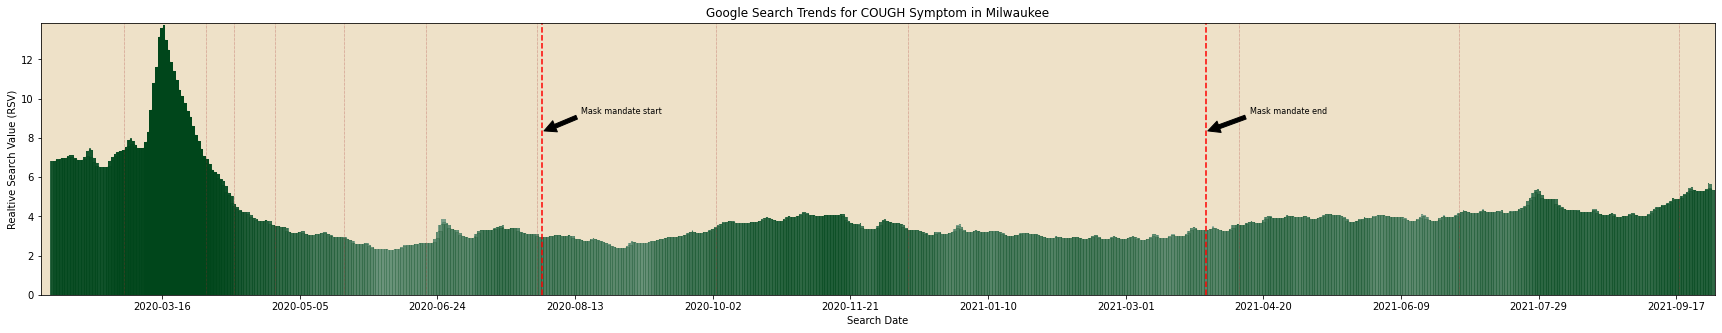

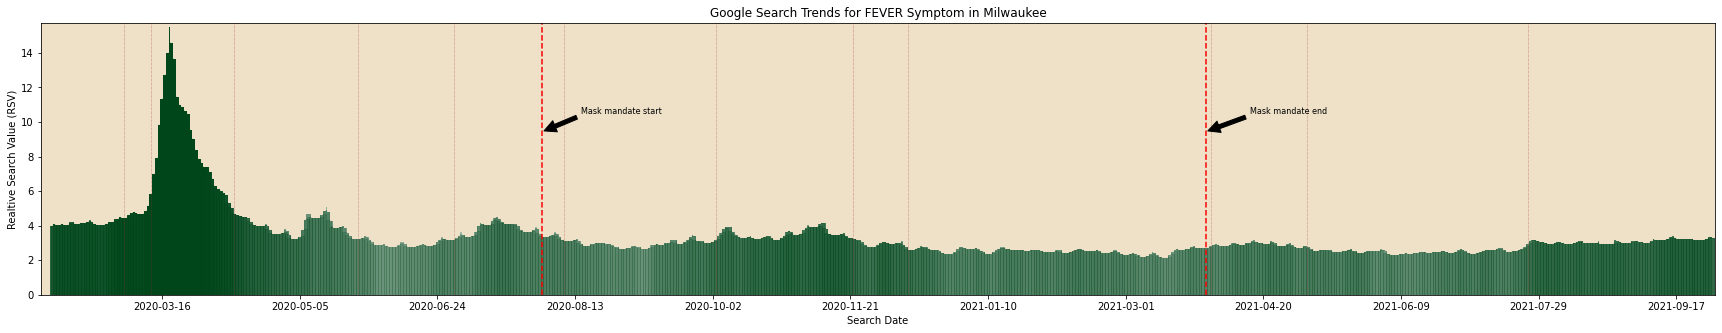

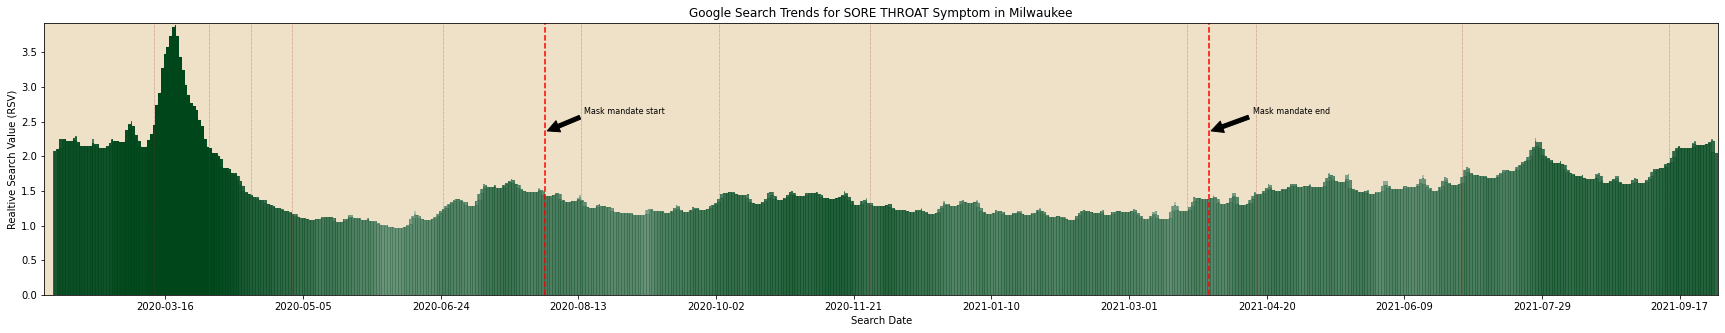

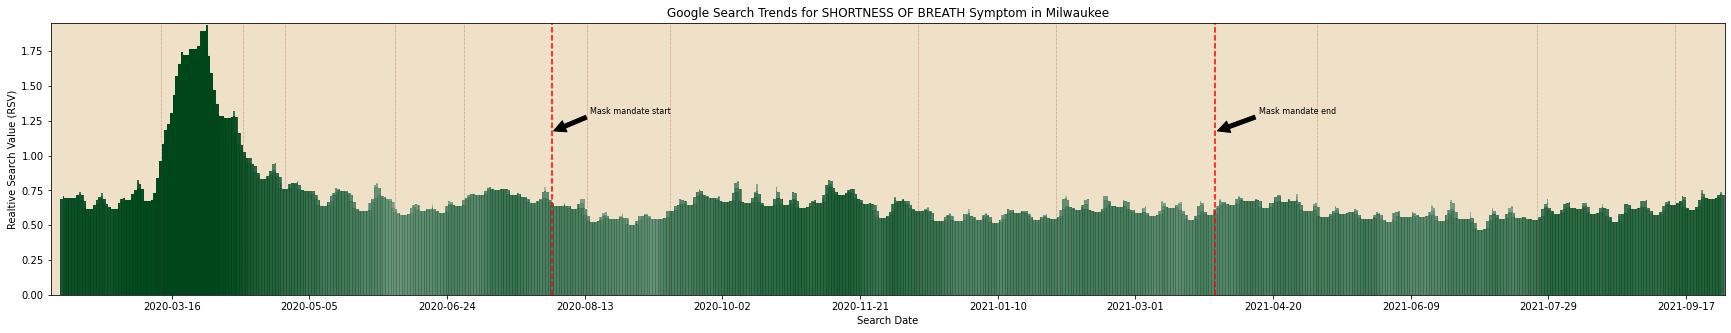

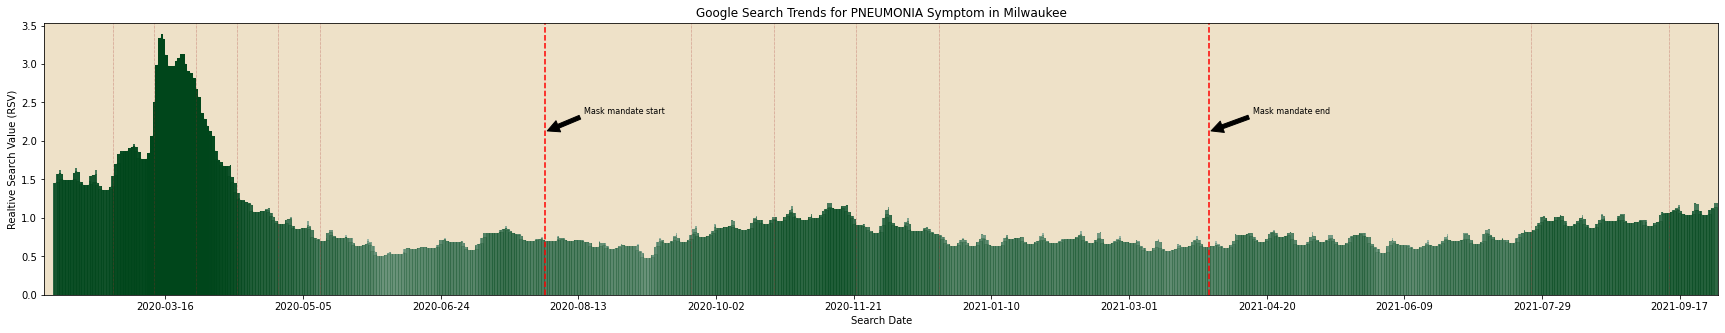

In [ ]:
plot_trends(top_symptoms)

### Obtain the time-lagged cross correlation between the COVID confirmed cases and top COVID symptom search terms

In [ ]:
def crosscorr(datax, datay, lag = 0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:
        return datax.corr(datay.shift(lag))

def window_corr(data, column):
  # Rolling window time lagged cross correlation
  window_size = 60 #samples
  t_start = 0
  t_end = t_start + window_size
  step_size = 2
  rss = []
  while t_end < data.shape[0]:
      d1 = data['cases'].iloc[t_start:t_end]
      d2 = data[column].iloc[t_start:t_end]
      rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(0, 15)]
      rss.append(rs)
      t_start = t_start + step_size
      t_end = t_end + step_size
  rss = pd.DataFrame(rss)
  return rss

def plot_corr(data1, data2, data3, column):
  f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 18))
  f.suptitle('Time Lagged Correlation plots before, during and after mask mandate in Milwaukee County')
  sns.heatmap(data1, cmap='RdBu_r',ax=ax1)
  ax1.set(title = f'Rolling Windowed Time Lagged Cross Correlation (Cases vs. %s Symptom Search) before mask mandate'% column.upper(), xlim=[0, 15], xlabel='Lag, days',ylabel='Window Epochs')
  ax1.set_xticklabels([int(item) for item in ax1.get_xticks()]);
  sns.heatmap(data2, cmap='RdBu_r',ax=ax2)
  ax2.set(title = f'Rolling Windowed Time Lagged Cross Correlation (Cases vs. %s Symptom Search) during mask mandate'% column.upper(), xlim=[0, 15], xlabel='Lag, days',ylabel='Window Epochs')
  ax2.set_xticklabels([int(item) for item in ax2.get_xticks()]);
  sns.heatmap(data3, cmap='RdBu_r',ax=ax3)
  ax3.set(title = f'Rolling Windowed Time Lagged Cross Correlation (Cases vs. %s Symptom Search) after mask mandate'% column.upper(), xlim=[0, 15], xlabel='Lag, days',ylabel='Window Epochs')
  ax3.set_xticklabels([int(item) for item in ax3.get_xticks()]);

In [ ]:
def plot_corr2(data, column):
  f, ax = plt.subplots(1, figsize=(12, 18))
  f.suptitle('Time Lagged Correlation plots before, during and after mask mandate in Milwaukee County')
  sns.heatmap(data, cmap='RdBu_r',ax=ax)
  ax.set(title = f'Rolling Windowed Time Lagged Cross Correlation (Cases vs. %s Symptom Search) before mask mandate'% column.upper(), xlim=[0, 15], xlabel='Lag, days',ylabel='Window Epochs')
  ax.set_xticklabels([int(item) for item in ax.get_xticks()]);

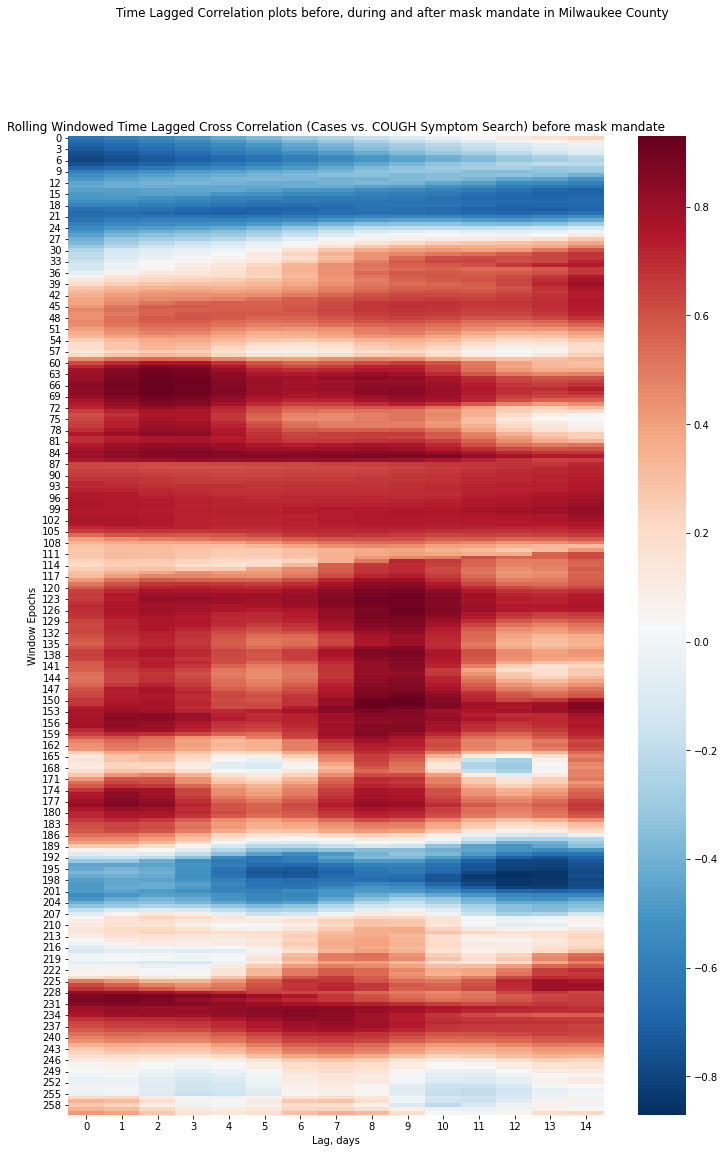

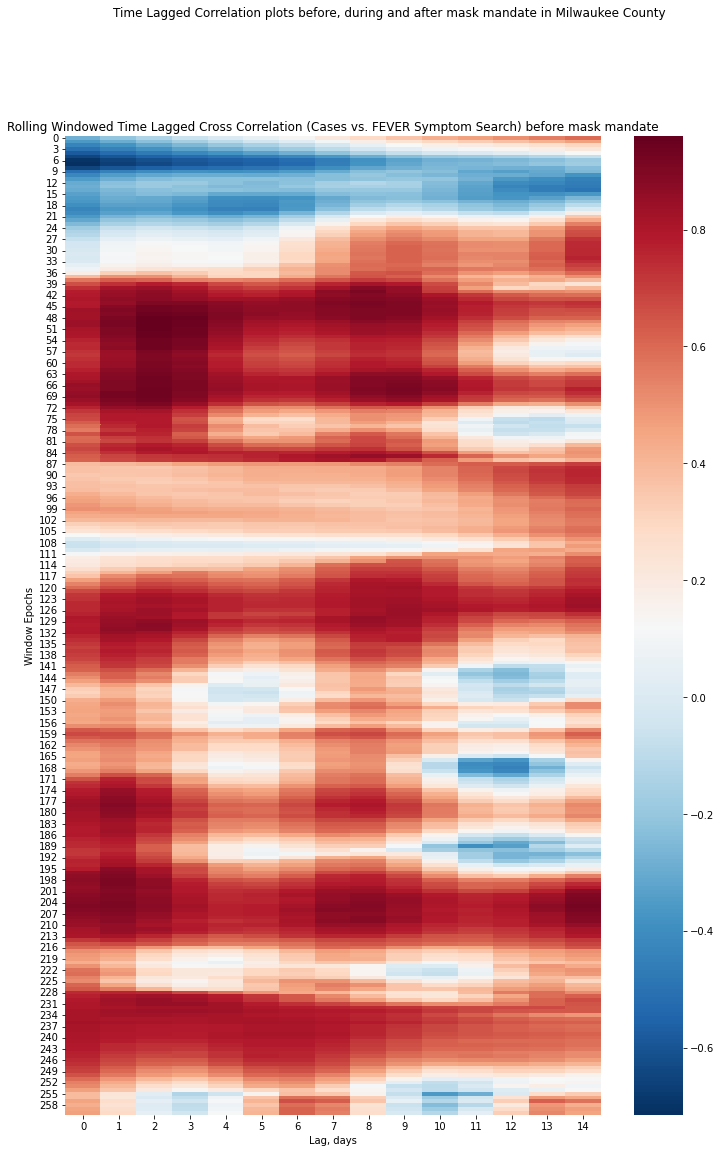

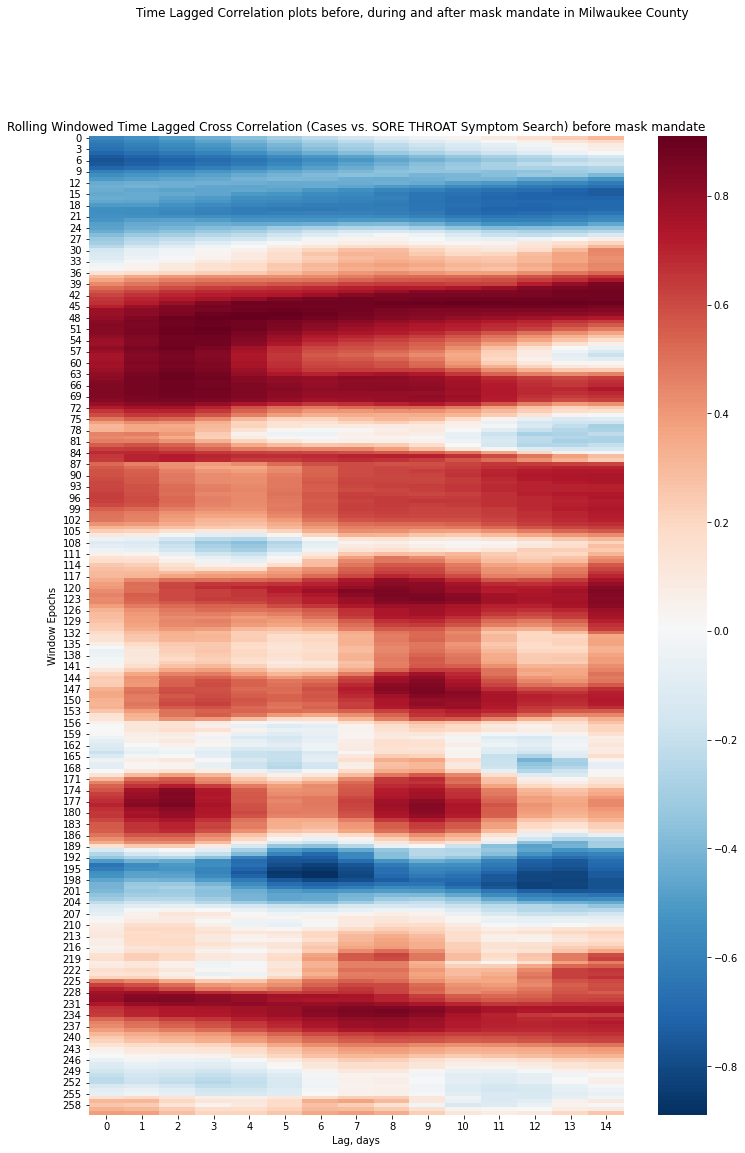

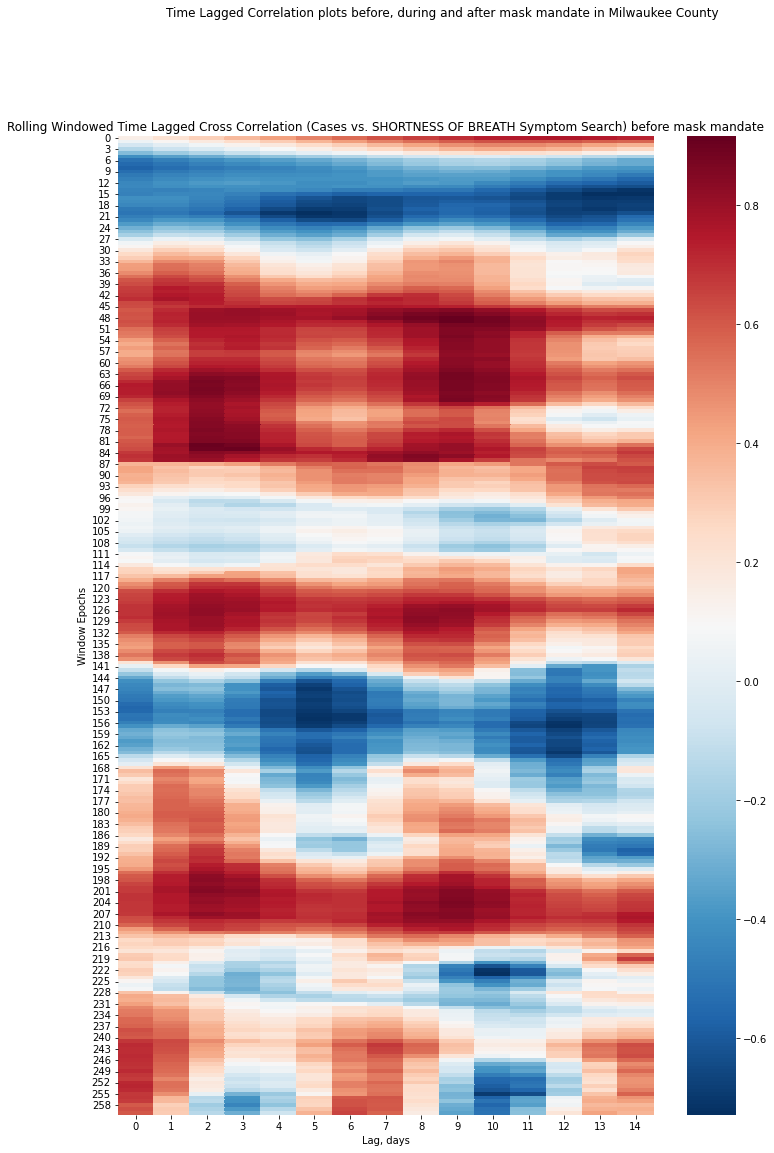

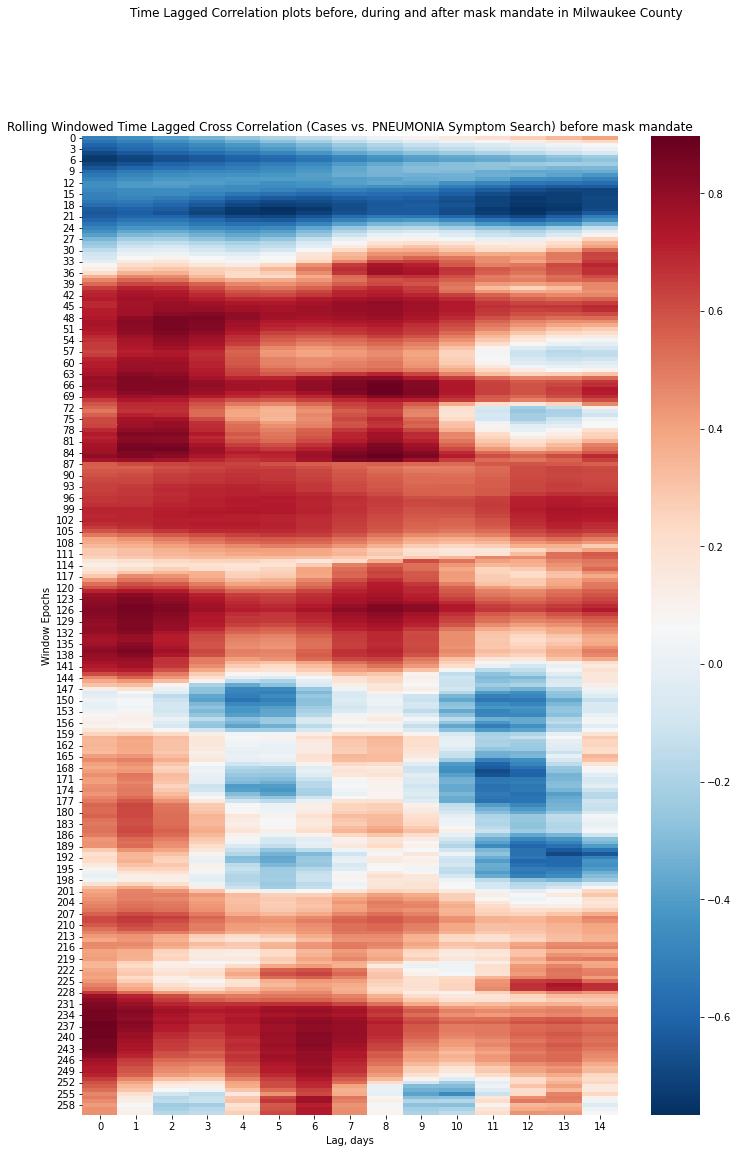

In [ ]:
for i in top_symptoms:
  rss = window_corr(df_wave1.append(df_wave2).append(df_wave3), i)
  plot_corr2(rss, i)

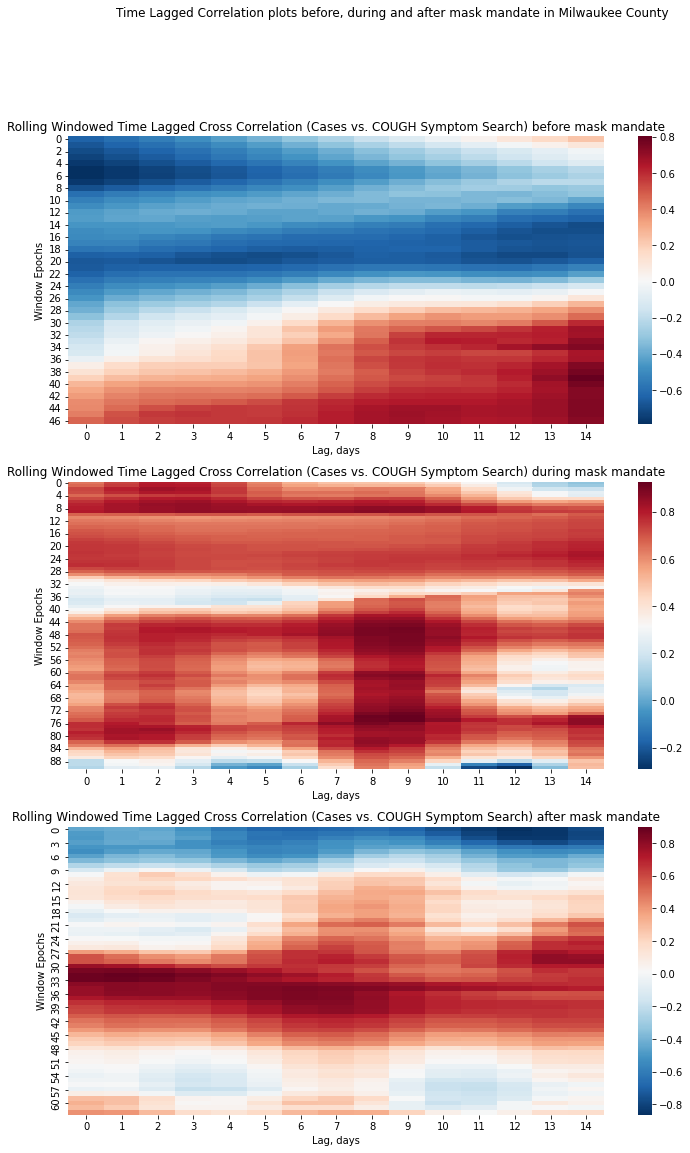

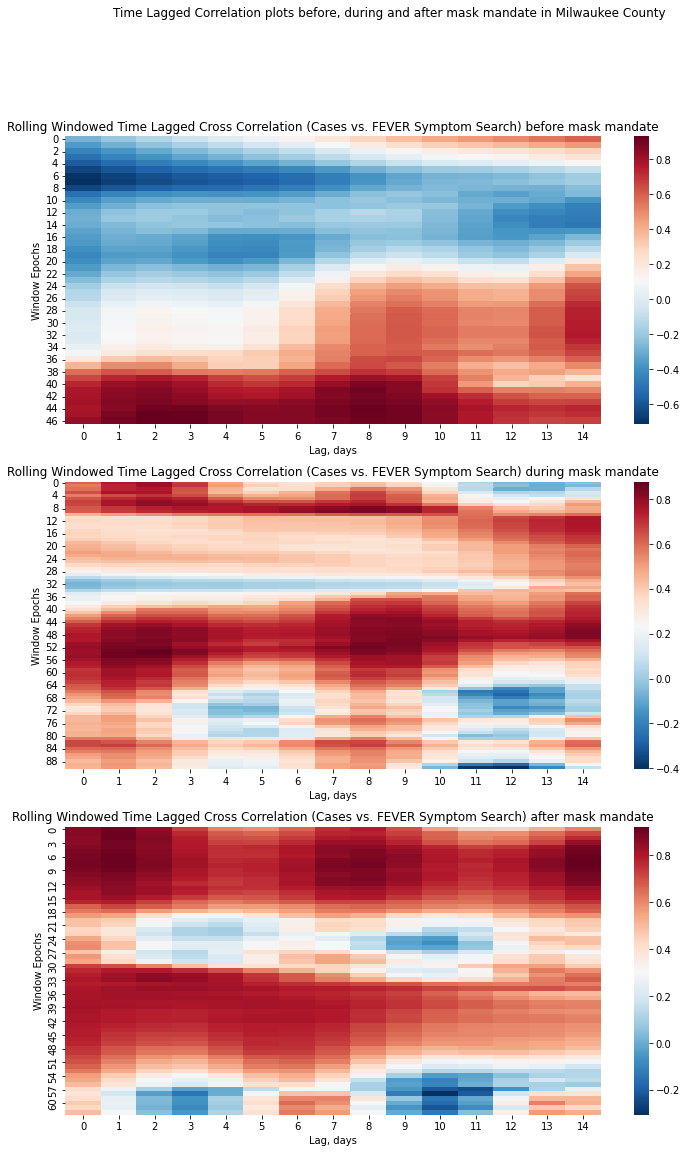

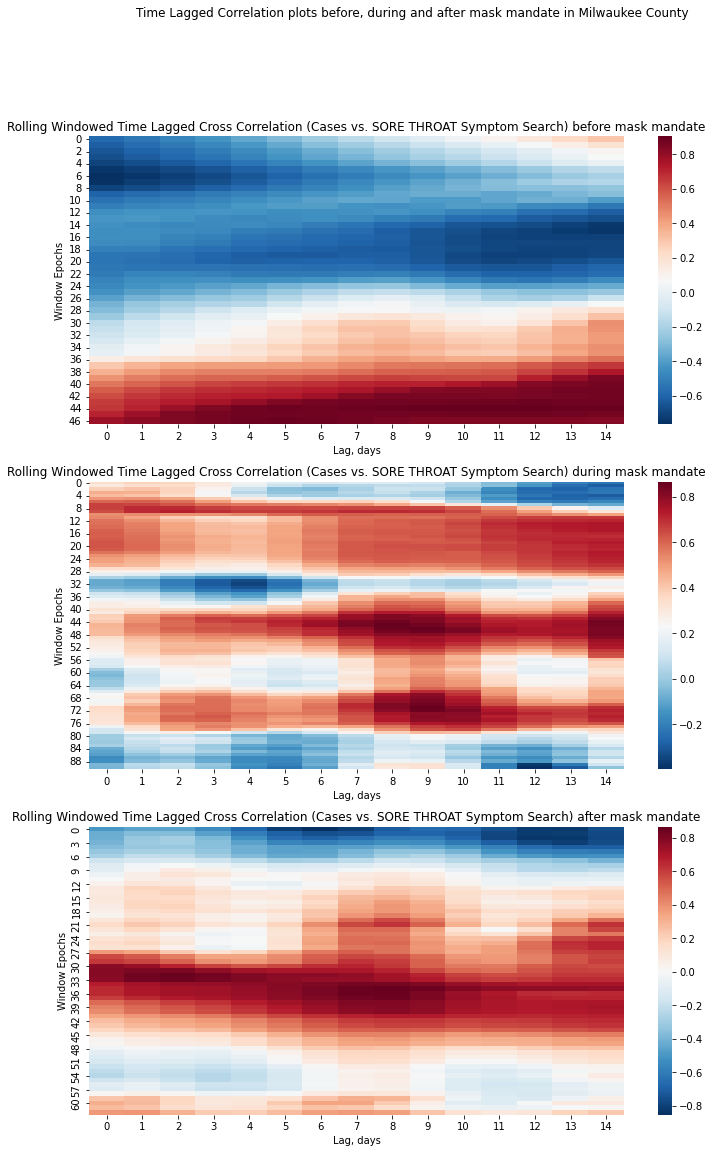

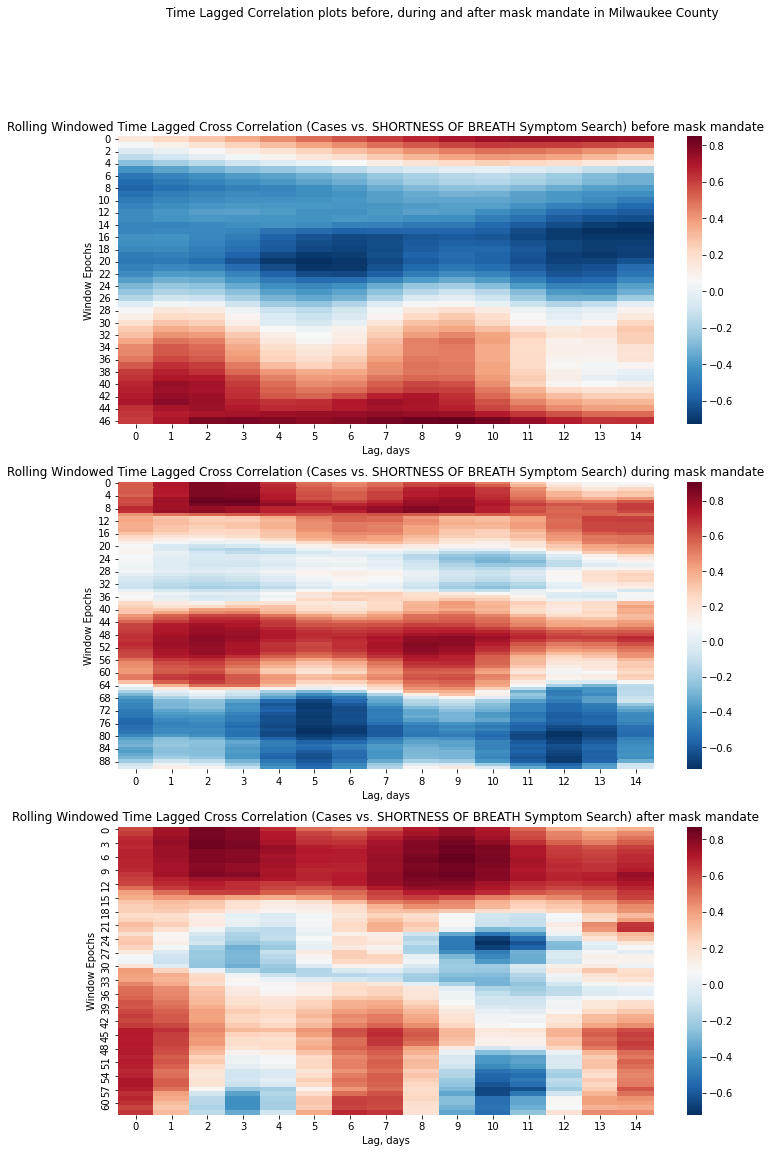

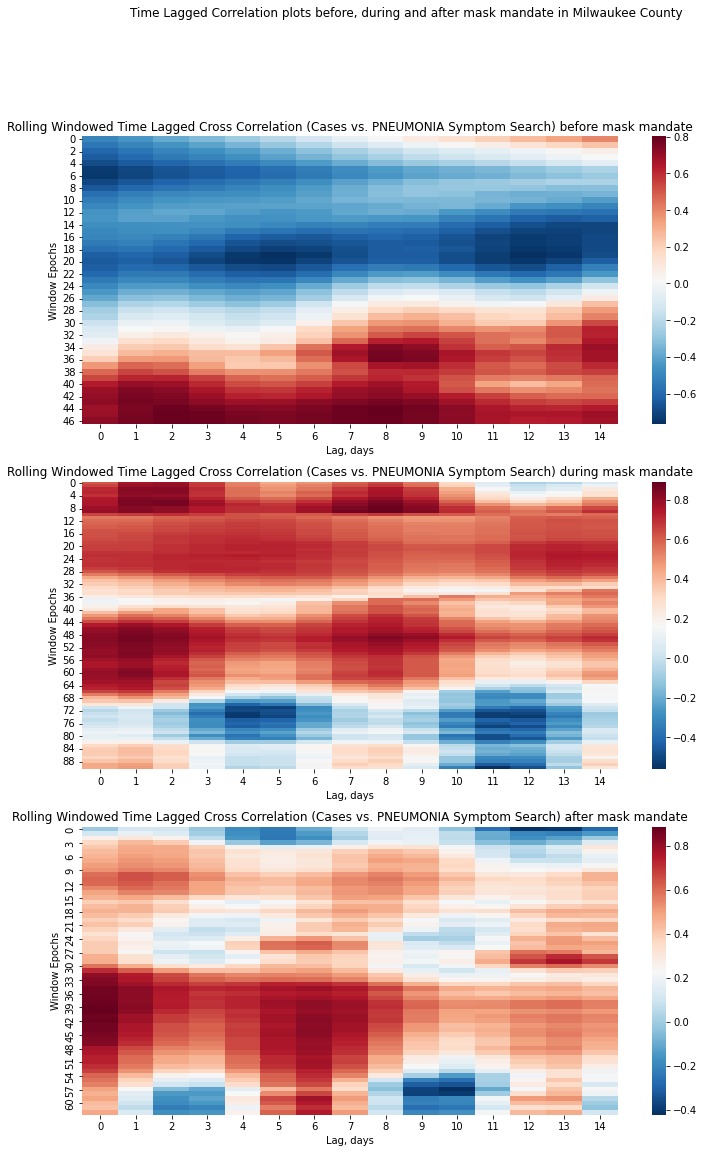

In [ ]:
for i in top_symptoms:
  rss1, rss2, rss3 = window_corr(df_wave1, i),window_corr(df_wave2, i), window_corr(df_wave3, i)
  plot_corr(rss1, rss2, rss3, i)

In [ ]:
vaccine_trends = df_vaccine.drop("key", axis = 1)
vaccine_trends = vaccine_trends[vaccine_trends['date'] <= '2021-10-01']

data = np.array(vaccine_trends['sni_covid19_vaccination'])
algo = rpt.Pelt(model="rbf").fit(data)
change_location = algo.predict(pen = 1)
change_location = df_vaccine.iloc[change_location[:-1]]['date'].to_list()

"\nfor x in change_location:\n  plt.axvline(x, lw = 0.5, color = 'brown', linestyle = ':')\n"

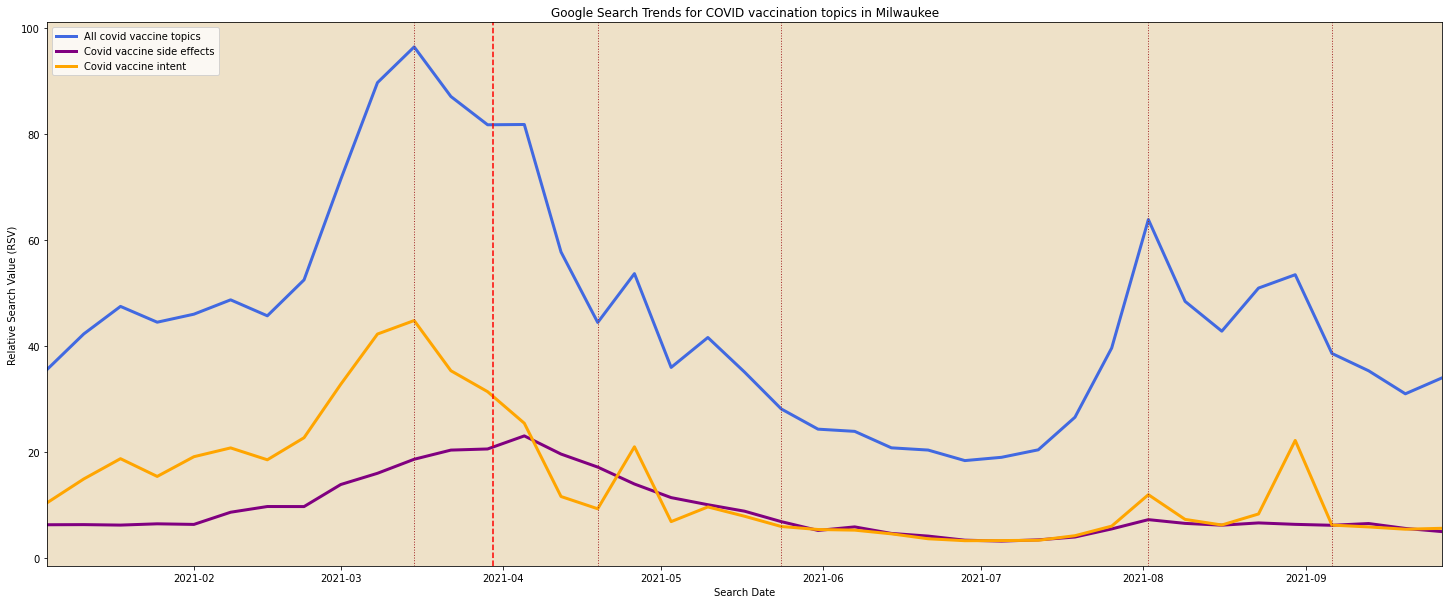

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.rcParams["figure.figsize"] = (25, 10)
#vaccine_trends[df_vaccine.columns[2:]] = vaccine_trends[df_vaccine.columns[2:]].rolling(2).mean()
#vaccine_trends = vaccine_trends.set_index('date')
plt.plot(vaccine_trends['date'], vaccine_trends['sni_covid19_vaccination'], color = 'royalblue', linewidth = 3)
plt.plot(vaccine_trends['date'], vaccine_trends['sni_safety_side_effects'], color = 'purple', linewidth = 3)
plt.plot(vaccine_trends['date'], vaccine_trends['sni_vaccination_intent'], color = 'orange', linewidth = 3)
xmin = min(vaccine_trends['date'])
xmax = max(vaccine_trends['date'])
plt.xlabel('Search Date')
plt.ylabel('Relative Search Value (RSV)')
plt.legend(['All covid vaccine topics', 'Covid vaccine side effects', 'Covid vaccine intent'])
plt.xlim([xmin, xmax])
#plt.axvline(x = pd.to_datetime('2020-08-01'), color = 'red', linestyle = '--', label = 'Mask Mandate Start')
plt.axvline(x = pd.to_datetime('2021-03-30'), color = 'red', linestyle = '--', label = 'Mask Mandate End')
#plt.annotate('Mask mandate start', xy=(pd.to_datetime('2020-08-01'), max(viz_trends[col]) * 1.8 / 3), xytext=(pd.to_datetime('2020-08-15'), max(viz_trends[col]) * 2 / 3), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
#plt.annotate('Mask mandate end', xy=(pd.to_datetime('2021-03-30'), max(viz_trends[col]) * 1.8 / 3), xytext=(pd.to_datetime('2021-04-15'), max(viz_trends[col]) * 2 / 3), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('Google Search Trends for COVID vaccination topics in Milwaukee')
ax.set_facecolor('#EEE1C8')
for x in change_location:
      plt.axvline(x, lw = 1, color = 'brown', linestyle = ':')
"""
for x in change_location:
  plt.axvline(x, lw = 0.5, color = 'brown', linestyle = ':')
""" 

### Difference in Difference Modeling

In [ ]:
mask_mandates_april_2020_aug_2021 = pd.read_csv("/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/archive/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
df_control_trends = pd.read_csv('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/data-512-project/US_NJ_34003.csv')
df_control_mask = mask_mandates_april_2020_aug_2021[(mask_mandates_april_2020_aug_2021['County_Name'] == 'Bergen County') & (mask_mandates_april_2020_aug_2021['State_Tribe_Territory'] == 'NJ')]

In [ ]:
cols = list(df_columns['column'])
df_control_trends = df_control_trends[df_control_trends.columns.intersection(cols)]
df_control_trends = df_control_trends[(df_control_trends['date'] >= '2020-02-01') & (df_control_trends['date'] <= '2021-10-01')]
df_control_trends = df_control_trends.fillna(0)

df_control_mask = df_control_mask[['date', 'Face_Masks_Required_in_Public']].rename(columns = {'Face_Masks_Required_in_Public': 'mask_required'})

df_control_mask['date'] = pd.to_datetime(df_control_mask['date'])
df_control_trends['date'] = pd.to_datetime(df_control_trends['date'])
df_control =  df_control_trends.merge(df_control_mask, how='inner', on='date')
df_control['mask_required'] = df_control['mask_required'].replace(np.nan, 'No')

df_control_wave1 = df_control[(df_control['date'] >= '2020-03-01') & (df_control['date'] < '2020-08-01')]
df_control_wave2 = df_control[(df_control['date'] >= '2020-08-01') & (df_control['date'] <= '2021-03-30')]
df_control_wave3 = df_control[df_control['date'] >= '2021-03-30']
df_control_wave1.reset_index(inplace = True)
df_control_wave2.reset_index(inplace = True)
df_control_wave3.reset_index(inplace = True)
df_control_wave1[covid_symptoms_short] = df_control_wave1[covid_symptoms]
df_control_wave1 = df_control_wave1.drop(covid_symptoms, axis = 1)
df_control_wave1 = df_control_wave1[top_symptoms + ["date", "mask_required"]]
df_control_wave2[covid_symptoms_short] = df_control_wave2[covid_symptoms]
df_control_wave2 = df_control_wave2.drop(covid_symptoms, axis = 1)
df_control_wave2 = df_control_wave2[top_symptoms + ["date", "mask_required"]]
df_control_wave3[covid_symptoms_short] = df_control_wave3[covid_symptoms]
df_control_wave3 = df_control_wave3.drop(covid_symptoms, axis = 1)
df_control_wave3 = df_control_wave3[top_symptoms + ["date", "mask_required"]]

df_treatment_wave1 = df_wave1[top_symptoms + ["date", "mask_required"]]
df_treatment_wave2 = df_wave2[top_symptoms + ["date", "mask_required"]]
df_treatment_wave3 = df_wave3[top_symptoms + ["date", "mask_required"]]

In [ ]:
df_control_did = df_control_wave1.sample(n = 60).append(df_control_wave2.sample(n = 180)).append((df_control_wave3[df_control_wave3['date'] <= '2021-05-27']).sample(n = 40))
#(df_control_wave1[df_control_wave1['date'] >= '2020-04-10']).append(df_control_wave2)
df_treatment_did = df_treatment_wave1.sample(n = 60).append(df_treatment_wave2.sample(n = 180)).append((df_treatment_wave3[df_treatment_wave3['date'] <= '2021-05-27']).sample(n = 40))
#(df_treatment_wave1[df_treatment_wave1['date'] >= '2020-04-10']).append(df_treatment_wave2)
print(df_control_did.shape, df_treatment_did.shape)

df_control_did['t'] = np.where((df_control_did['date'] >= '2020-08-01') & (df_control_did['date'] <= '2021-03-30') ,1, 0)
df_control_did['g'] = 0
df_treatment_did['t'] = np.where((df_treatment_did['date'] >= '2020-08-01') & (df_treatment_did['date'] <= '2021-03-30') ,1, 0)
df_treatment_did['g'] = 1

df_did = df_control_did.append(df_treatment_did)
df_did['month'] = df_did['date'].dt.month
df_did['year'] = df_did['date'].dt.year
df_did = df_did.drop(["date", "mask_required"], axis = 1)
df_did['gt'] = df_did['g']*df_did['t']
df_did.reset_index(inplace = True)
df_did = df_did.drop("index", axis = 1)
df_did.head()

(280, 7) (280, 7)


,cough,fever,sore throat,shortness of breath,pneumonia,t,g,month,year,gt
0,4.83,5.93,1.39,1.13,1.73,0,0,4,2020,0
1,2.47,4.08,1.17,0.67,0.62,0,0,7,2020,0
2,3.64,10.08,1.26,0.78,0.99,0,0,5,2020,0
3,2.52,3.42,1.00,0.68,0.75,0,0,6,2020,0
4,5.59,6.45,1.58,1.36,2.04,0,0,4,2020,0


In [ ]:
did_groupby = df_did.groupby(['g', 't']).mean().drop(['gt', 'month', 'year'], axis = 1)
did_groupby = did_groupby.reset_index()
did_groupby

,g,t,cough,fever,sore throat,shortness of breath,pneumonia
0,0,0,3.507400,4.585400,1.277900,0.771000,0.917400
1,0,1,3.416556,3.824056,1.303556,0.691278,0.911333
2,1,0,4.427121,4.084596,1.604848,0.789949,1.039545
3,1,1,3.292928,2.993329,1.304213,0.649254,0.806823


In [ ]:
def ols_regression(df, columns):
  coeff = []
  for i in columns:
    did = sm.OLS(endog = df[i], exog = df[['g', 't', 'gt', 'year', 'month']]).fit()
    coeff.append(round(did.params[2], 3))
  return coeff

In [ ]:
coeffs = ols_regression(df_did, top_symptoms)
df_coeffs = pd.DataFrame(coeffs).T
df_coeffs.columns = top_symptoms
df_coeffs.head()

,cough,fever,sore throat,shortness of breath,pneumonia
0,-1.042,-0.334,-0.327,-0.061,-0.227


Text(0, 0.5, 'Relative Seach Value (RSV)')

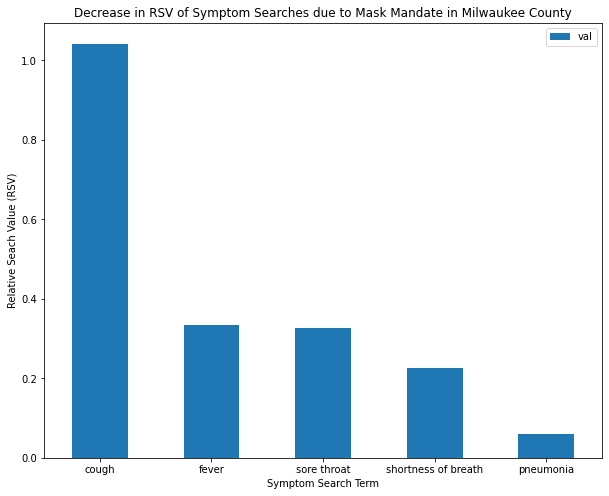

In [ ]:
coeffs.sort(reverse=False)
df = pd.DataFrame({'symptom':top_symptoms, 'val':list(map(abs, coeffs))})
ax = df.plot.bar(x='symptom', y='val', rot=0, figsize=(10, 8))
plt.title('Decrease in RSV of Symptom Searches due to Mask Mandate in Milwaukee County')
plt.xlabel('Symptom Search Term')
plt.ylabel('Relative Seach Value (RSV)')

In [ ]:
pct_change_treatment = -1 * np.array(coeffs) * 100 / np.array(did_groupby[(did_groupby['g'] == 1) & (did_groupby['t'] == 0)].iloc[:,2:])
pct_change_treatment = list(pct_change_treatment[0])

pct_change_control = 1 * (1 - (np.array(did_groupby[(did_groupby['g'] == 0) & (did_groupby['t'] == 1)].iloc[:,2:]) / np.array(did_groupby[(did_groupby['g'] == 0) & (did_groupby['t'] == 0)].iloc[:,2:])))*100
pct_change_control = list(pct_change_control[0])

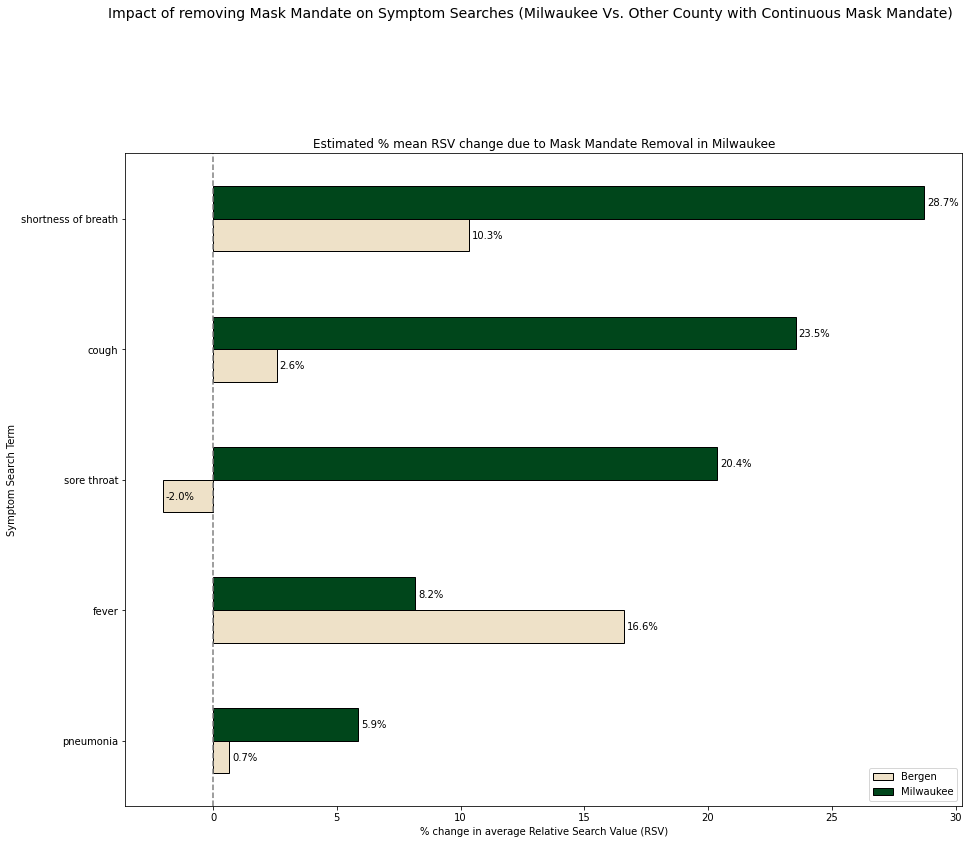

In [ ]:
viz_did = pd.DataFrame({'Bergen': pct_change_control, 'Milwaukee': pct_change_treatment}, index = top_symptoms)
viz_did = viz_did.sort_values(by=['Milwaukee'], ascending = True)
ax = viz_did.plot(kind = "barh", rot=0, figsize = (15, 12), color = ['#EEE1C8', '#00461B'], edgecolor='black')
plt.suptitle('Impact of removing Mask Mandate on Symptom Searches (Milwaukee Vs. Other County with Continuous Mask Mandate)', y=1.05, fontsize=14)
plt.title('Estimated % mean RSV change due to Mask Mandate Removal in Milwaukee', fontsize=12)
plt.ylabel('Symptom Search Term')
plt.xlabel('% change in average Relative Search Value (RSV)')
plt.axvline(x = 0, color = 'gray', linestyle = '--', label = 'No change in RSV values')
for p in ax.patches:
  ax.annotate(str(round(p.get_width(), 1)) + '%', (p.get_width() + 0.1, p.get_y() + 0.1))

# Inference from overall analysis

Below is the inference drawn from various metrics calculated using the provided COVID data for milwaukee county. These metrics were compared against the masking mandate policy implemented. Below are few of the findings.

**Incidence Rate or Positive Per capita Plot:**

We can observe that after the before the mask mandate is enforced, the spread category is uncontrolled (red band) indicating the necessity for a mask mandate. Post the mask mandate is implemented, we can notice that the phase shifted into a controlled band (orange) and stayed for 60 time intervals (2 months). The same trend can be observed before the masking mandate end. However, the impact of removing the mandate can be seen in the next 30 time intervals (1 month). This shows a clear impact of masking on the positive cases per capita in milwaukee.  

**Growth Factor Plot: **

The growth factor plot shows a clear indication of how the GF values have died down after the mask mandate started and the impact lasted for almost 2 months before it spiked again during the next wave of COVID. High growth factor values are again observed after the mask mandate was relaxed in April 2021.

**Transmission Rate Plot:**

In the plot, we can observe that transmission rate has gone down after the masking mandate has started. This also indicates how the spread of the virus has gone down after people following the mandate. However, the transmission rate peaked immediately after the mandate is removed but came down after a month. This can be because of the vaccination phase that started and implementing second doses to mass population.

**Infection Rate Plot (with changepoints):**

From the 4th change point, we can observe that how the masking mandate brought down the infection rate. This change shows an evidence of the impact of masking policy. From the 8th change point to 9th, there is no huge difference in infection rates. Hence, removing masking policy can be attributed to the stability. However, at the final change point (10th) the COVID infection rate started to peak.

**Derivative of Infection Rate (with changepoints):**

We can observe that the after 4th change point after the maasking mandate started, the derivate is more closer to 0 indicating the change in infection rate over time is not frequent. The same pattern can be observed after removing the mandate but oscillated more at the end.

Overall, it is evident from the above analysis as to why there arose a necessity for enforcing and removing masking policy. The analysis clearly shows an impact of masking on infection rate and how it accelerated after the mandate is removed. However, there are few exceptions where observed, where we see peak infection rates even after the masking policy is in place. This can be attributed to high impact of other aspects like vaccinations, recovery rates, hospitalizations